In [ ]:
# Auto-reload extension - automatically reloads modules when they change
# This will automatically reload all modules (except those excluded by %aimport)
# every time before executing a new line of code
%load_ext autoreload
%autoreload 2

# Week 1 of Topics in Statistics: Markov chain Monte Carlo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/carsten-j/mc-lab/blob/main/notebooks/week1.ipynb)

## Most of the examples from chapter 2 and 3 

This notebook implements most of the examples in chapter 2 and 3 using functionality from the `mc_lab` package.

In [2]:
# Check if mc-lab-edu is installed, install if not
import importlib.util

# Check if mc_lab package is available
spec = importlib.util.find_spec("mc_lab")

if spec is None:
    print("📦 Installing mc-lab-edu with numpy <2.0 compatibility for Colab...")
    !pip install mc-lab-edu==0.2.5
    print("✅ mc-lab-edu has been installed successfully!")
else:
    print("✅ mc-lab-edu is already installed")

print("🎉 Ready to use mc-lab!")

✅ mc-lab-edu is already installed
🎉 Ready to use mc-lab!


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from mc_lab.box_muller import box_muller
from mc_lab.distribution_comparison import distribution_comparison
from mc_lab.importance_sampling import ImportanceSampler
from mc_lab.inverse_transform import InverseTransformSampler
from mc_lab.moment_comparison import compare_distribution_moments
from mc_lab.plotting import plot_distribution_analysis
from mc_lab.rejection_sampling import RejectionSampler

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

sns.set_theme(style="darkgrid")
sns.color_palette("tab10")

n_samples = 10000

# Inversion Method

The inverse transform method is a fundamental technique for generating random samples from probability distributions. If $U \sim \text{Uniform}(0,1)$ and $F$ is a cumulative distribution function (CDF), then $X = F^{-1}(U)$ follows the distribution with CDF $F$.

## Example 2.1: Exponential Distribution via Inverse Transform

**Problem**: Generate samples from an exponential distribution with rate parameter $\lambda$ using the inverse transform method.

**Theory**: 
- CDF: $F(x) = 1 - e^{-\lambda x}$ for $x \geq 0$
- Inverse CDF: $F^{-1}(u) = -\frac{\ln(1-u)}{\lambda}$
- If $U \sim \text{Uniform}(0,1)$, then $X = F^{-1}(U) \sim \text{Exponential}(\lambda)$

In [1]:
def exponential_inverse_cdf(u, rate=1.0):
    """
    Inverse CDF for exponential distribution.

    Parameters:
    -----------
    u : float or array-like
        Uniform random variables in [0, 1]
    rate : float
        Rate parameter (lambda > 0)

    Returns:
    --------
    Exponential random variables
    """
    u = np.asarray(u)  # Ensure u is a numpy array to handle lists
    return -np.log(1 - u) / rate


# Parameters for the exponential distribution
rate_param = 2.0  # lambda = 2


In [4]:
sampler_exp = InverseTransformSampler(
    inverse_cdf=lambda u: exponential_inverse_cdf(u, rate=rate_param), random_state=42
)

samples_custom = sampler_exp.sample(n_samples)

scipy_samples = stats.expon.rvs(scale=1 / rate_param, size=n_samples, random_state=42)


In [5]:
_ = distribution_comparison(samples_custom, scipy_samples, alpha=0.05)

Distribution Comparison Results:
Distribution Test         Statistic    P-value      Significant at α={alpha}
--------------------------------------------------------------------------------
Kolmogorov-Smirnov        0.000000     1.000000     No                  
Anderson-Darling          -1.313491    0.250000     No                  
Cramér-von Mises          0.000000     1.000000     No                  


/home/carstenj/dev/mc-lab/src/mc_lab/distribution_comparison.py:14: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([s1, s2])


In [ ]:
normal_results = compare_distribution_moments(
    scipy_dist=stats.expon,
    dist_params={"scale": 1 / rate_param},
    samples=samples_custom,
)


MOMENT COMPARISON REPORT
Distribution: expon
Parameters: {'scale': 0.5}
Sample Size: 10000
------------------------------------------------------------
  Moment  Theoretical  Empirical  Relative Error           95% CI  p-value Significant
    Mean         0.50   0.488749        0.022501 [0.4796, 0.4988] 0.020952        True
Variance         0.25   0.237366        0.050535 [0.2242, 0.2508] 0.000283        True
     Std         0.50   0.487202        0.025595 [0.4735, 0.5008]      NaN         N/A
Skewness         2.00   1.918977        0.040512 [1.8048, 2.0281] 0.000940        True
Kurtosis         6.00   5.115054        0.147491 [4.2587, 5.9926] 0.000000        True


Scipy Exponential Distribution Mean: 0.5


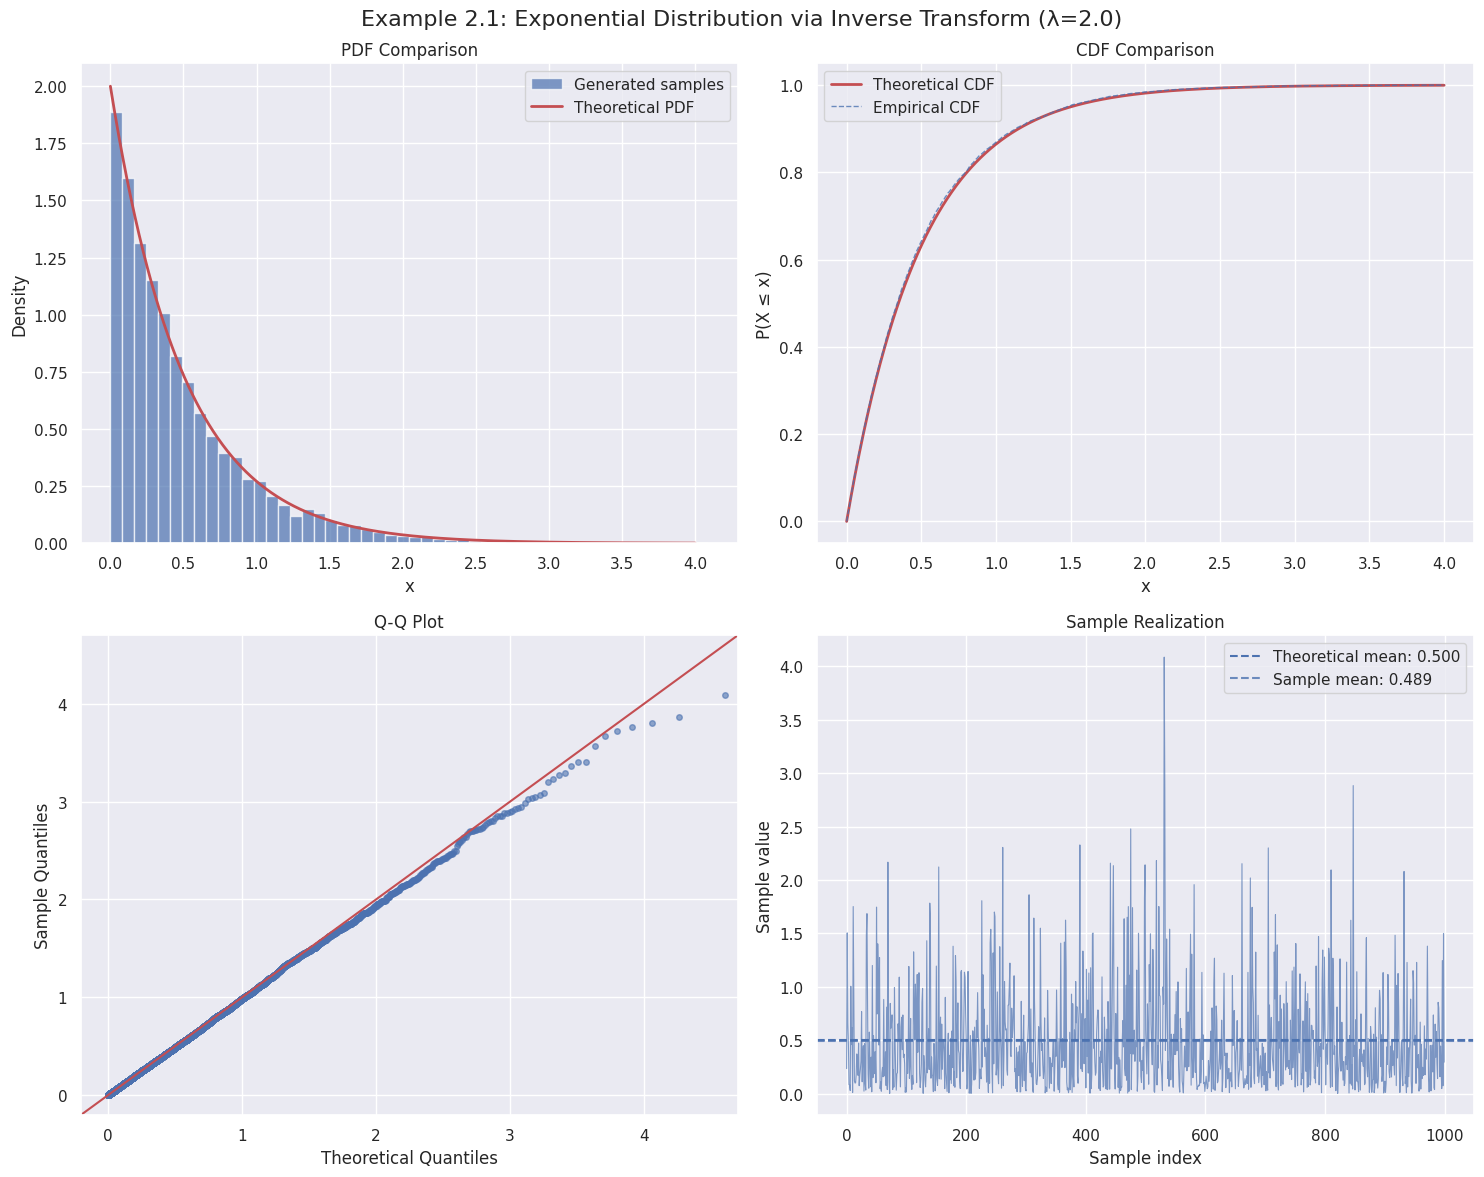

In [23]:
# Visualization for Example 2.1: Exponential Distribution
scipy_exp_dist = stats.expon(scale=1 / rate_param)

print(f"Scipy Exponential Distribution Mean: {scipy_exp_dist.mean()}")

# Calculate the required statistics
theoretical_mean = 1 / rate_param
sample_mean = np.mean(samples_custom)


plot_distribution_analysis(
    samples=samples_custom,
    distribution_name="Exponential",
    example_number="2.1",
    method_description=f"Inverse Transform (λ={rate_param})",
    theoretical_mean=theoretical_mean,
    sample_mean=sample_mean,
    scipy_dist=scipy_exp_dist,
    x_range=(0, 4),
)

## Example 2.2: Cauchy Distribution via Inverse Transform

**Problem**: Generate samples from a Cauchy distribution with location parameter $x_0$ and scale parameter $\gamma$ using the inverse transform method.

**Theory**: 
- CDF: $F(x) = \frac{1}{\pi}\arctan\left(\frac{x-x_0}{\gamma}\right) + \frac{1}{2}$ for $x \in \mathbb{R}$
- Inverse CDF: $F^{-1}(u) = x_0 + \gamma \tan\left(\pi\left(u - \frac{1}{2}\right)\right)$
- If $U \sim \text{Uniform}(0,1)$, then $X = F^{-1}(U) \sim \text{Cauchy}(x_0, \gamma)$

In [9]:
# Example 2.2: Cauchy Distribution
def cauchy_inverse_cdf(u, location=0.0, scale=1.0):
    """
    Inverse CDF for Cauchy distribution.

    Parameters:
    -----------
    u : float or array-like
        Uniform random variables in [0, 1]
    location : float
        Location parameter x₀ (median)
    scale : float
        Scale parameter γ > 0

    Returns:
    --------
    Cauchy random variables
    """
    u = np.asarray(u)  # Ensure u is a numpy array to handle lists
    return location + scale * np.tan(np.pi * (u - 0.5))


# Parameters for the Cauchy distribution
location_param = 2.0  # x₀ = 2 (median/mode)
scale_param = 1.5  # γ = 1.5 (scale parameter)


In [ ]:
# Generate Cauchy samples using mc_lab's InverseTransformSampler
sampler_cauchy = InverseTransformSampler(
    inverse_cdf=lambda u: cauchy_inverse_cdf(
        u, location=location_param, scale=scale_param
    ),
    random_state=42,
)

samples_cauchy = sampler_cauchy.sample(n_samples)

scipy_cauchy_samples = stats.cauchy.rvs(
    loc=location_param, scale=scale_param, size=n_samples, random_state=42
)


In [14]:
_ = distribution_comparison(samples_cauchy, scipy_cauchy_samples, alpha=0.05)

Distribution Comparison Results:
Distribution Test         Statistic    P-value      Significant at α={alpha}
--------------------------------------------------------------------------------
Kolmogorov-Smirnov        0.000100     1.000000     No                  
Anderson-Darling          -1.313071    0.250000     No                  
Cramér-von Mises          0.000014     1.000000     No                  


/home/carstenj/dev/mc-lab/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/home/carstenj/dev/mc-lab/src/mc_lab/distribution_comparison.py:14: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([s1, s2])


In [ ]:
_ = compare_distribution_moments(
    scipy_dist=stats.cauchy,
    dist_params={"loc": 2, "scale": 1},
    samples=samples_cauchy,
    robust=True,  # Use robust estimators for heavy-tailed data
)


/home/carstenj/dev/mc-lab/src/mc_lab/moment_comparison.py:45: UserWarning: Cauchy distribution has no finite moments!
  warnings.warn("Cauchy distribution has no finite moments!")



MOMENT COMPARISON REPORT
Distribution: cauchy
Parameters: {'loc': 2, 'scale': 1}
Sample Size: 10000
------------------------------------------------------------
  Moment  Theoretical  Empirical  Relative Error                   95% CI  p-value Significant
    Mean          NaN   1.964785             NaN       [-15.1336, 1.1306]      NaN         N/A
Variance          NaN   4.782164             NaN [4119.7529, 569044.8725]      NaN         N/A
     Std          NaN   2.186816             NaN      [64.1853, 754.3506]      NaN         N/A
Skewness          NaN  -0.018998             NaN     [-96.6035, -20.7583]      NaN         N/A
Kurtosis          NaN   1.643016             NaN    [933.9596, 9534.5631]      NaN         N/A


In [ ]:
# Validation: Compare with scipy's Cauchy distribution

# Statistical test
ks_stat_cauchy, p_value_cauchy = stats.ks_2samp(samples_cauchy, scipy_cauchy_samples)

print("Validation against scipy.stats.cauchy:")
print(f"Kolmogorov-Smirnov test statistic: {ks_stat_cauchy:.6f}")
print(f"P-value: {p_value_cauchy:.6f}")
print(f"Test result: {'PASS' if p_value_cauchy > 0.05 else 'FAIL'} (α = 0.05)")
print()

# Additional validation: Check specific quantiles
test_quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
our_quantiles = sampler_cauchy.sample_quantiles(test_quantiles)
scipy_quantiles = stats.cauchy.ppf(
    test_quantiles, loc=location_param, scale=scale_param
)

print("Quantile comparison:")
print("Quantile | Our method | SciPy | Difference")
print("-" * 45)
for i, q in enumerate(test_quantiles):
    diff = abs(our_quantiles[i] - scipy_quantiles[i])
    print(
        f"{q:8.2f} | {our_quantiles[i]:10.4f} | {scipy_quantiles[i]:10.4f} | {diff:.2e}"
    )

Validation against scipy.stats.cauchy:
Kolmogorov-Smirnov test statistic: 0.000100
P-value: 1.000000
Test result: PASS (α = 0.05)

Quantile comparison:
Quantile | Our method | SciPy | Difference
---------------------------------------------
    0.10 |    -2.6165 |    -2.6165 | 1.78e-15
    0.25 |     0.5000 |     0.5000 | 6.66e-16
    0.50 |     2.0000 |     2.0000 | 0.00e+00
    0.75 |     3.5000 |     3.5000 | 4.44e-16
    0.90 |     6.6165 |     6.6165 | 2.66e-15


/home/carstenj/dev/mc-lab/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


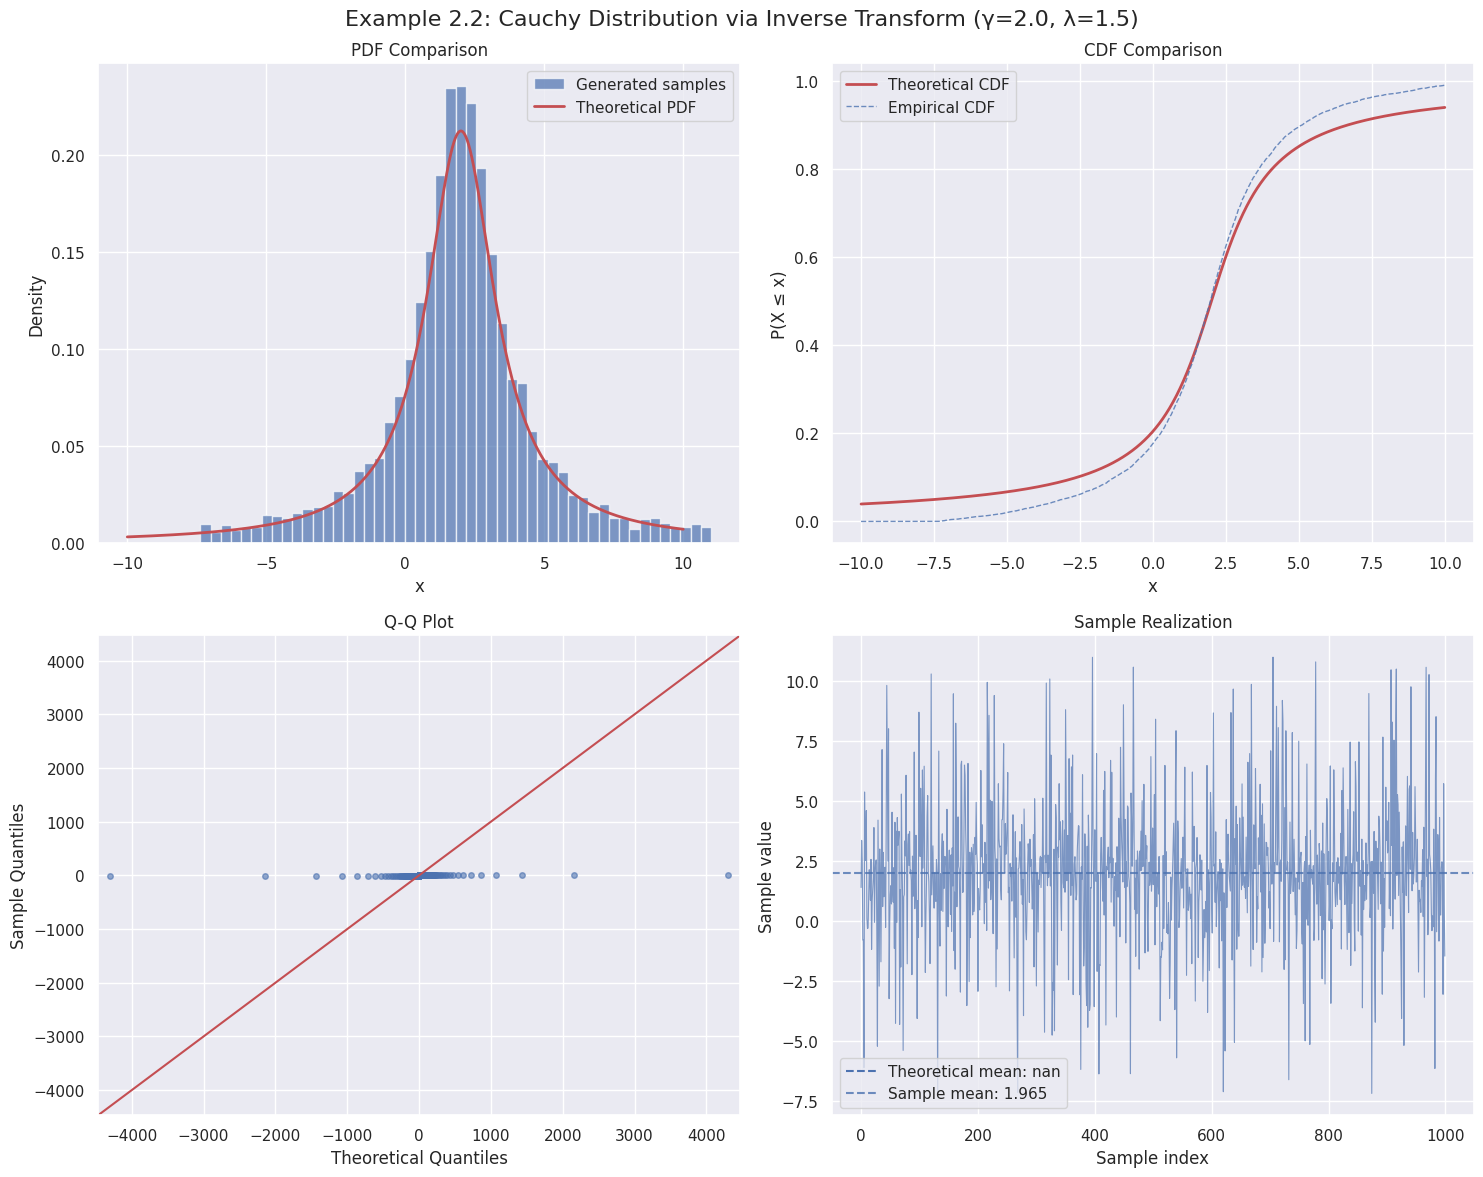

In [16]:
# Visualization for Example 2.2: Cauchy Distribution
scipy_cauchy_dist = stats.cauchy(loc=location_param, scale=scale_param)

# Create trimmed samples for better visualization (remove extreme outliers)
# Trim to 5th and 95th percentiles to handle heavy tails
q05, q95 = np.percentile(samples_cauchy, [5, 95])
samples_cauchy_trimmed = samples_cauchy[
    (samples_cauchy >= q05) & (samples_cauchy <= q95)
]

# For sample mean, use median since mean is undefined for Cauchy
sample_median = np.median(samples_cauchy)

plot_distribution_analysis(
    samples=samples_cauchy_trimmed,
    distribution_name="Cauchy",
    example_number="2.2",
    method_description=f"Inverse Transform (γ={location_param}, λ={scale_param})",
    theoretical_mean=float("nan"),  # Cauchy has no defined mean
    sample_mean=sample_median,  # Use median instead of mean
    scipy_dist=scipy_cauchy_dist,
    x_range=(-10, 10),
)

# Transformation Methods

## Example 3.1: Gamma Distribution via Sum of Exponentials

**Problem**: Generate samples from a Gamma distribution $\text{Ga}(\alpha, \beta)$ using the property that if $Y_i \sim \text{Exp}(1)$ for $i = 1, 2, \ldots, \alpha$ (where $\alpha \in \mathbb{N}$), then $X = \beta^{-1} \sum_{i=1}^{\alpha} Y_i \sim \text{Ga}(\alpha, \beta)$.

**Theory**: 
- Gamma distribution: $\text{Ga}(\alpha, \beta)$ with shape parameter $\alpha > 0$ and rate parameter $\beta > 0$
- PDF: $f(x) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x}$ for $x \geq 0$
- Mean: $\mathbb{E}[X] = \alpha / \beta$
- Variance: $\text{Var}[X] = \alpha / \beta^2$
- Method: Sum $\alpha$ independent $\text{Exp}(1)$ random variables and scale by $\beta^{-1}$

In [12]:
def sample_gamma_via_exponentials(
    n_samples, alpha, beta, exponential_sampler, random_state=None
):
    """
    Generate Gamma(alpha, beta) samples using sum of exponentials.

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    alpha : int
        Shape parameter (must be positive integer)
    beta : float
        Rate parameter (beta > 0)
    exponential_sampler : InverseTransformSampler
        Sampler for Exp(rate_param) distribution
    random_state : int or None
        Random seed for reproducibility

    Returns:
    --------
    numpy.ndarray
        Gamma distributed samples
    """
    if not isinstance(alpha, int) or alpha <= 0:
        raise ValueError("alpha must be a positive integer for this method")

    # Generate alpha independent Exp(rate_param) samples for each of n_samples
    # Note: sampler_exp generates Exp(rate_param), so we need to scale to get Exp(1)

    # Get the rate parameter from the exponential sampler (assuming it's rate_param)
    exp_rate = rate_param  # This is the rate parameter of our exponential sampler

    gamma_samples = np.zeros(n_samples)

    for i in range(n_samples):
        # Generate alpha exponential samples and sum them
        exp_sum = 0
        for j in range(alpha):
            # Sample from Exp(rate_param) and convert to Exp(1) by multiplying by rate_param
            exp_sample = exponential_sampler.sample(
                1, random_state=random_state + i * alpha + j if random_state else None
            )[0]
            exp_sum += exp_sample * exp_rate  # Convert Exp(rate_param) to Exp(1)

        # Scale the sum by 1/beta to get Gamma(alpha, beta)
        gamma_samples[i] = exp_sum / beta

    return gamma_samples

In [13]:
# Parameters for Gamma distribution
alpha_param = 3  # Shape parameter (integer for this method)
beta_param = 2.0  # Rate parameter


# Generate samples using our method with the existing exponential sampler
samples_gamma = sample_gamma_via_exponentials(
    n_samples, alpha_param, beta_param, sampler_exp, random_state=42
)


# Validation: Compare with scipy's gamma distribution
scipy_gamma_samples = stats.gamma.rvs(
    a=alpha_param, scale=1 / beta_param, size=n_samples, random_state=42
)


In [14]:
_ = distribution_comparison(samples_gamma, scipy_gamma_samples, alpha=0.05)

Distribution Comparison Results:
Kolmogorov-Smirnov Test:
  Statistic: 0.012600
  P-value: 0.405357
  Significant at α=0.05: No

Anderson-Darling Test:
  Statistic: -0.078566
  P-value: 0.250000
  Significant at α=0.05: No

Cramér-von Mises Test:
  Statistic: 0.083862
  P-value: 0.669886
  Significant at α=0.05: No


/home/carstenj/dev/mc-lab/src/mc_lab/distribution_comparison.py:14: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([s1, s2])


In [15]:
normal_results = compare_distribution_moments(
    scipy_dist=stats.gamma,
    dist_params={"a": alpha_param, "scale": 1 / beta_param},
    samples=samples_gamma,
    plot=False,  # Set to True to see plots
)


MOMENT COMPARISON REPORT
Distribution: gamma
Parameters: {'a': 3, 'scale': 0.5}
Sample Size: 10000
------------------------------------------------------------
  Moment  Theoretical  Empirical  Relative Error           95% CI  p-value Significant
    Mean     1.500000   1.512074        0.008049 [1.4964, 1.5295] 0.165453       False
Variance     0.750000   0.757741        0.010322 [0.7297, 0.7834] 0.464147       False
     Std     0.866025   0.870483        0.005148 [0.8542, 0.8851]      NaN         N/A
Skewness     1.154701   1.093364        0.053119 [1.0321, 1.1539] 0.012277        True
Kurtosis     2.000000   1.526864        0.236568 [1.2472, 1.8140] 0.000000        True


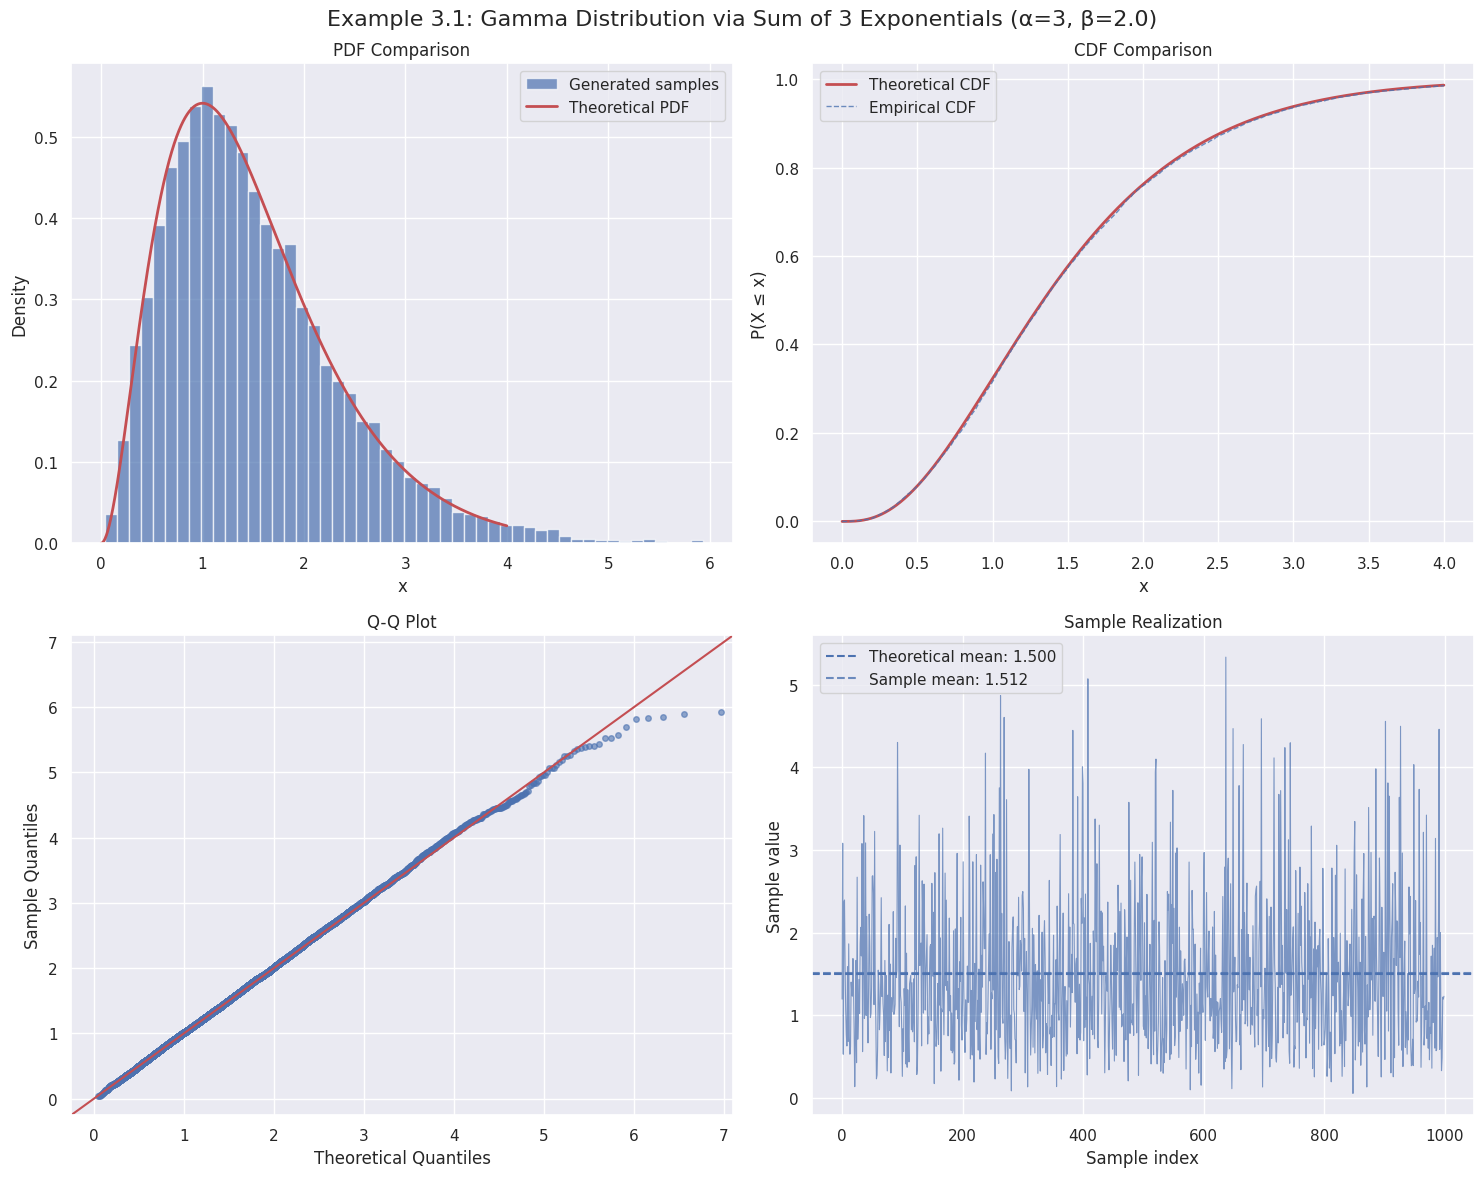

In [17]:
# Visualization for Example 3.1: Gamma Distribution
scipy_gamma_dist = stats.gamma(a=alpha_param, scale=1 / beta_param)

theoretical_mean_gamma = alpha_param / beta_param
sample_mean_gamma = np.mean(samples_gamma)

plot_distribution_analysis(
    samples=samples_gamma,
    distribution_name="Gamma",
    example_number="3.1",
    method_description=f"Sum of {alpha_param} Exponentials (α={alpha_param}, β={beta_param})",
    theoretical_mean=theoretical_mean_gamma,
    sample_mean=sample_mean_gamma,
    scipy_dist=scipy_gamma_dist,
    x_range=(0, 4),
)

## Example 3.2: Beta Distribution via Gamma Ratio

**Problem**: Generate samples from a Beta distribution $\text{Beta}(\alpha, \beta)$ using the property that if $X_1 \sim \text{Ga}(\alpha, 1)$ and $X_2 \sim \text{Ga}(\beta, 1)$ are independent, then $\frac{X_1}{X_1 + X_2} \sim \text{Beta}(\alpha, \beta)$.

**Theory**: 
- Beta distribution: $\text{Beta}(\alpha, \beta)$ with shape parameters $\alpha > 0$ and $\beta > 0$
- PDF: $f(x) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} x^{\alpha-1} (1-x)^{\beta-1}$ for $x \in [0,1]$
- Mean: $\mathbb{E}[X] = \frac{\alpha}{\alpha + \beta}$
- Variance: $\text{Var}[X] = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$
- Method: Generate two independent Gamma variables and take their ratio

In [18]:
# Example 3.2: Beta Distribution via Gamma Ratio
def sample_beta_via_gamma_ratio(
    n_samples, alpha, beta, exponential_sampler, random_state=None
):
    """
    Generate Beta(alpha, beta) samples using ratio of Gamma variables.

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    alpha : int
        First shape parameter (must be positive integer for our Gamma method)
    beta : int
        Second shape parameter (must be positive integer for our Gamma method)
    exponential_sampler : InverseTransformSampler
        Sampler for exponential distribution
    random_state : int or None
        Random seed for reproducibility

    Returns:
    --------
    numpy.ndarray
        Beta distributed samples
    """
    # Generate X1 ~ Gamma(alpha, 1) using our exponential sum method
    gamma1_samples = sample_gamma_via_exponentials(
        n_samples, alpha, 1.0, exponential_sampler, random_state
    )

    # Generate X2 ~ Gamma(beta, 1) using our exponential sum method
    # Use different seed to ensure independence
    seed2 = random_state + 1000 if random_state is not None else None
    gamma2_samples = sample_gamma_via_exponentials(
        n_samples, beta, 1.0, exponential_sampler, seed2
    )

    # Beta samples = X1 / (X1 + X2)
    beta_samples = gamma1_samples / (gamma1_samples + gamma2_samples)

    return beta_samples


# Parameters for Beta distribution
alpha_beta = 3  # First shape parameter
beta_beta = 2  # Second shape parameter (using different name to avoid confusion)


# Generate samples using our method with the existing exponential sampler
samples_beta = sample_beta_via_gamma_ratio(
    n_samples, alpha_beta, beta_beta, sampler_exp, random_state=42
)
scipy_beta_samples = stats.beta.rvs(
    a=alpha_beta, b=beta_beta, size=n_samples, random_state=42
)

In [19]:
_ = distribution_comparison(samples_beta, scipy_beta_samples, alpha=0.05)

Distribution Comparison Results:
Kolmogorov-Smirnov Test:
  Statistic: 0.008800
  P-value: 0.833544
  Significant at α=0.05: No

Anderson-Darling Test:
  Statistic: -0.592415
  P-value: 0.250000
  Significant at α=0.05: No

Cramér-von Mises Test:
  Statistic: 0.051495
  P-value: 0.867220
  Significant at α=0.05: No


/home/carstenj/dev/mc-lab/src/mc_lab/distribution_comparison.py:14: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([s1, s2])


In [20]:
normal_results = compare_distribution_moments(
    scipy_dist=stats.beta,
    dist_params={"a": alpha_beta, "b": beta_beta},
    samples=samples_beta,
    plot=False,  # Set to True to see plots
)


MOMENT COMPARISON REPORT
Distribution: beta
Parameters: {'a': 3, 'b': 2}
Sample Size: 10000
------------------------------------------------------------
  Moment  Theoretical  Empirical  Relative Error             95% CI  p-value Significant
    Mean     0.600000   0.598028        0.003287   [0.5943, 0.6021] 0.325799       False
Variance     0.040000   0.040293        0.007313   [0.0393, 0.0412] 0.602699       False
     Std     0.200000   0.200730        0.003650   [0.1982, 0.2031]      NaN         N/A
Skewness    -0.285714  -0.294960        0.032361 [-0.3266, -0.2638] 0.705830       False
Kurtosis    -0.642857  -0.657192        0.022299 [-0.7003, -0.6077] 0.769817       False


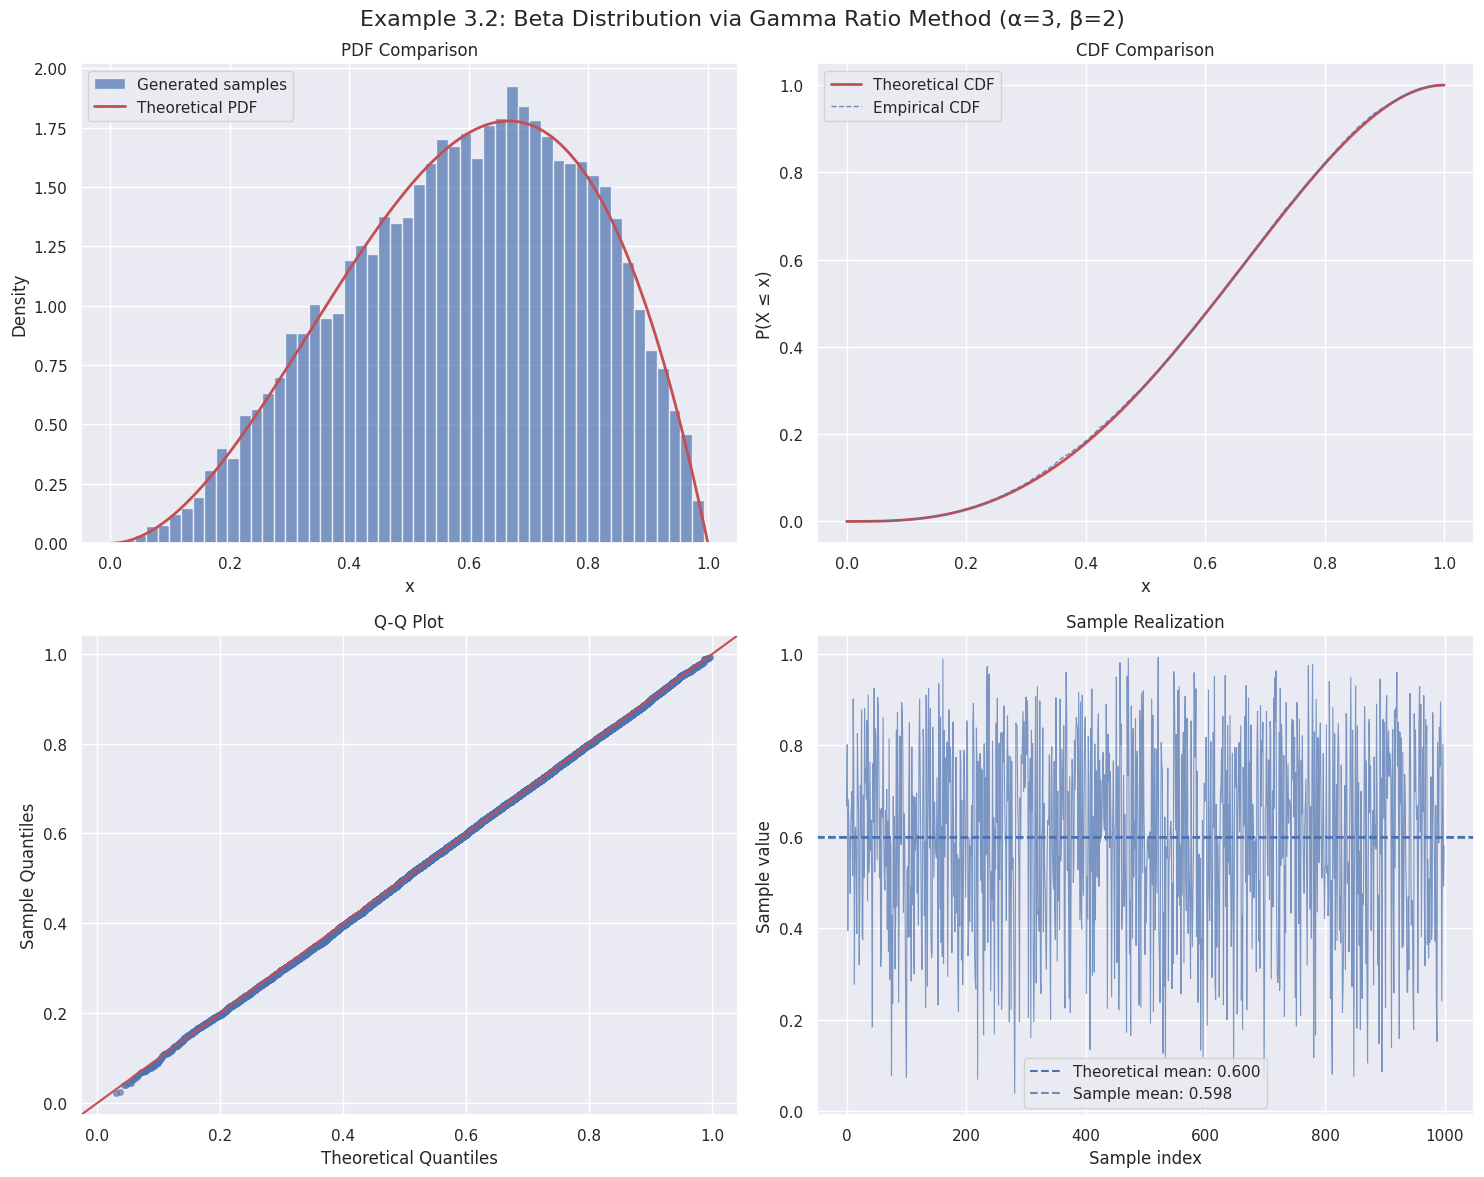

In [21]:
theoretical_mean_beta = alpha_beta / (alpha_beta + beta_beta)
sample_mean_beta = np.mean(samples_beta)

# Visualization for Example 3.2: Beta Distribution
scipy_beta_dist = stats.beta(a=alpha_beta, b=beta_beta)
plot_distribution_analysis(
    samples=samples_beta,
    distribution_name="Beta",
    example_number="3.2",
    method_description=f"Gamma Ratio Method (α={alpha_beta}, β={beta_beta})",
    theoretical_mean=theoretical_mean_beta,
    sample_mean=sample_mean_beta,
    scipy_dist=scipy_beta_dist,
    x_range=(0, 1),
)

## Example 4.1: Gaussian Distribution via Box-Muller Transform

**Problem**: Generate samples from a standard normal distribution $\mathcal{N}(\mu, \sigma^2)$ using the Box-Muller transformation method.

**Theory**: 
- Normal distribution: $\mathcal{N}(\mu, \sigma^2)$ with mean $\mu$ and variance $\sigma^2$
- PDF: $f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$ for $x \in \mathbb{R}$
- Mean: $\mathbb{E}[X] = \mu$
- Variance: $\text{Var}[X] = \sigma^2$
- **Box-Muller Method**: Transform two independent $U(0,1)$ variables to two independent $\mathcal{N}(0,1)$ variables:
  - $Z_1 = \sqrt{-2\ln U_1} \cos(2\pi U_2)$
  - $Z_2 = \sqrt{-2\ln U_1} \sin(2\pi U_2)$
- For general $\mathcal{N}(\mu, \sigma^2)$: $X = \mu + \sigma Z$ where $Z \sim \mathcal{N}(0,1)$

In [23]:
standard_normal_samples = box_muller(n=n_samples, method="classic", random_state=42)

scipy_normal_samples = stats.norm.rvs(loc=0, scale=1, size=n_samples, random_state=42)


In [24]:
# Validate theoretical moments
theoretical_mean_normal = 0
sample_mean_normal = np.mean(standard_normal_samples)


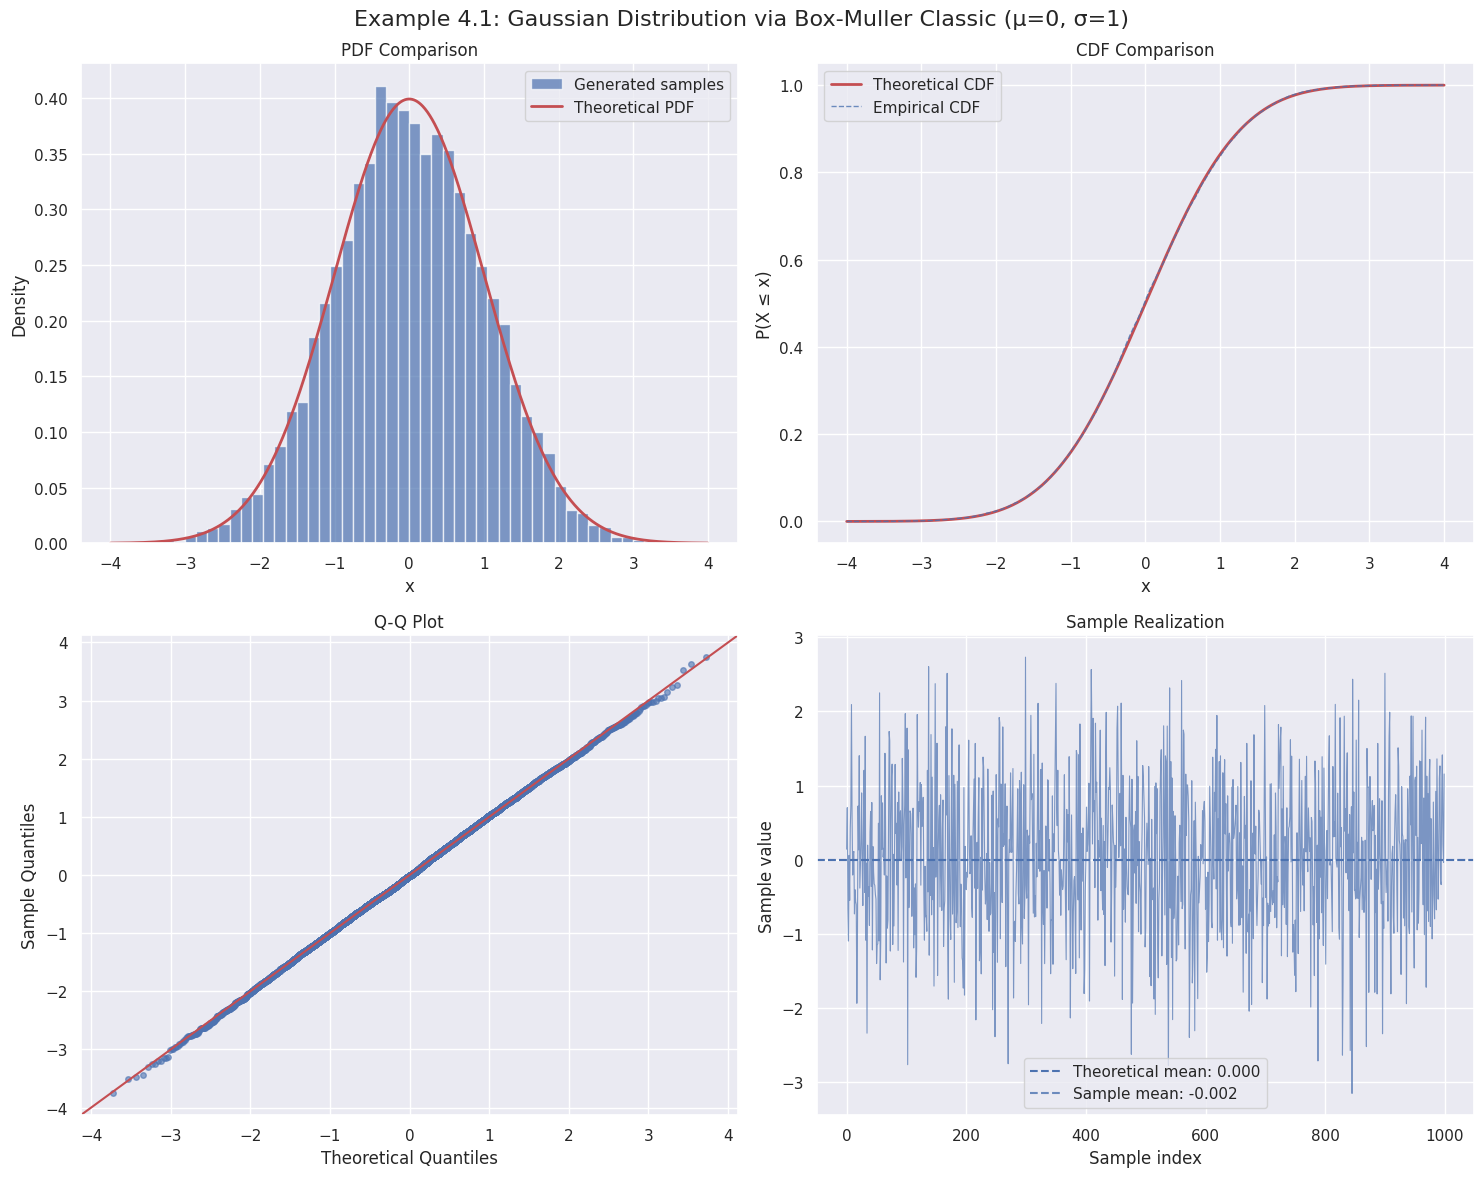

In [25]:
# Visualization for Example 4.1: Gaussian Distribution
scipy_normal_dist = stats.norm(loc=0, scale=1)

# Calculate appropriate x-range based on 3-sigma rule
x_min = 0 - 4 * 1
x_max = 0 + 4 * 1

plot_distribution_analysis(
    samples=standard_normal_samples,
    distribution_name="Gaussian",
    example_number="4.1",
    method_description=f"Box-Muller Classic (μ={0}, σ={1})",
    theoretical_mean=theoretical_mean_normal,
    sample_mean=sample_mean_normal,
    scipy_dist=scipy_normal_dist,
    x_range=(x_min, x_max),
)

# Rejection Sampling

## Example 5.2: Beta Distribution via Rejection Sampling

**Problem**: Generate samples from a Beta distribution $\text{Beta}(\alpha, \beta)$ using rejection sampling with different proposal distributions depending on the parameter values.

**Theory**: 
- **Target distribution**: $\tilde{\pi}(x) = x^{\alpha-1}(1-x)^{\beta-1}$ for $x \in (0,1)$ (unnormalized Beta density)
- **Case 1**: For $\alpha, \beta \geq 1$, the distribution is upper bounded on $[0,1]$
  - **Proposal**: $q(x) = \mathbb{I}_{(0,1)}(x)$ (Uniform on $(0,1)$)
  - **Bound**: $M = \sup_x \frac{\tilde{\pi}(x)}{q(x)} = \frac{(\alpha-1)^{\alpha-1}(\beta-1)^{\beta-1}}{(\alpha+\beta-2)^{\alpha+\beta-2}}$
- **Case 2**: For $\alpha < 1, \beta \geq 1$, we need a different proposal to handle the singularity at $x=0$
  - **Proposal**: $q(x) = \alpha x^{\alpha-1} \mathbb{I}_{(0,1)}(x)$
  - **Bound**: $M = \sup_x \frac{\tilde{\pi}(x)}{q(x)} = \sup_x \frac{(1-x)^{\beta-1}}{\alpha} = \frac{1}{\alpha}$

**Method**: 
1. Generate $Y \sim q(\cdot)$ (proposal distribution)
2. Generate $U \sim \text{Uniform}(0,1)$  
3. Accept $Y$ if $U \leq \frac{\tilde{\pi}(Y)}{M \cdot q(Y)}$
4. Otherwise reject and repeat

In [ ]:
# Example 5.2a: Beta Distribution via Rejection Sampling - Case 1 (α, β ≥ 1)

# Parameters for Case 1: α, β ≥ 1
alpha_rej1 = 2.5
beta_rej1 = 3.5


# Define target PDF (unnormalized Beta density)
def target_pdf_case1(x):
    """Unnormalized Beta PDF: x^(α-1) * (1-x)^(β-1)"""
    if x <= 0 or x >= 1:
        return 0.0
    return x ** (alpha_rej1 - 1) * (1 - x) ** (beta_rej1 - 1)


# Define proposal PDF (Uniform on (0,1))
def proposal_pdf_case1(x):
    """Uniform density on (0,1)"""
    if 0 < x < 1:
        return 1.0
    return 0.0


# Define proposal sampler (Uniform on (0,1))
def proposal_sampler_case1(n):
    """Sample from Uniform(0,1)"""
    return np.random.uniform(0, 1, n)


# Calculate theoretical bound M for Case 1
# M = (α-1)^(α-1) * (β-1)^(β-1) / (α+β-2)^(α+β-2)
if alpha_rej1 >= 1 and beta_rej1 >= 1:
    M_case1 = (
        (alpha_rej1 - 1) ** (alpha_rej1 - 1)
        * (beta_rej1 - 1) ** (beta_rej1 - 1)
        / (alpha_rej1 + beta_rej1 - 2) ** (alpha_rej1 + beta_rej1 - 2)
    )
    print(f"Theoretical bound M = {M_case1:.6f}")
else:
    M_case1 = None
    print("Using adaptive M estimation")

# Create rejection sampler
sampler_beta_rej1 = RejectionSampler(
    target_pdf=target_pdf_case1,
    proposal_pdf=proposal_pdf_case1,
    proposal_sampler=proposal_sampler_case1,
    M=M_case1,
    adaptive_M=False if M_case1 else True,
)

# Generate samples
print("Generating samples...")
samples_beta_rej1 = sampler_beta_rej1.sample(n_samples)

# Get sampling statistics
stats_case1 = sampler_beta_rej1.get_stats()
print("Sampling completed!")
print(f"Acceptance rate: {stats_case1['acceptance_rate']:.4f}")
print(f"Total proposals: {stats_case1['total_proposals']}")
print(f"Used M value: {stats_case1['current_M']:.6f}")

Theoretical bound M = 0.070916
Generating samples...
Sampling completed!
Acceptance rate: 0.5187
Total proposals: 19300
Used M value: 0.070916

Sample mean: 0.4152
Sample variance: 0.034500
Sample standard deviation: 0.185743
Sample range: [0.003720, 0.954617]



In [ ]:
# Example 5.2b: Beta Distribution via Rejection Sampling - Case 2 (α < 1, β ≥ 1)

# Parameters for Case 2: α < 1, β ≥ 1
alpha_rej2 = 0.7
beta_rej2 = 2.0


# Define target PDF (unnormalized Beta density)
def target_pdf_case2(x):
    """Unnormalized Beta PDF: x^(α-1) * (1-x)^(β-1)"""
    if x <= 0 or x >= 1:
        return 0.0
    return x ** (alpha_rej2 - 1) * (1 - x) ** (beta_rej2 - 1)


# Define proposal PDF: q(x) = α * x^(α-1) for x ∈ (0,1)
def proposal_pdf_case2(x):
    """Power distribution density: α * x^(α-1) on (0,1)"""
    if 0 < x < 1:
        return alpha_rej2 * x ** (alpha_rej2 - 1)
    return 0.0


# Define proposal sampler: X = U^(1/α) where U ~ Uniform(0,1)
def proposal_sampler_case2(n):
    """Sample from power distribution using inverse transform"""
    u = np.random.uniform(0, 1, n)
    return u ** (1.0 / alpha_rej2)


# Calculate theoretical bound M for Case 2
# M = sup_x (1-x)^(β-1) / α = 1/α (achieved at x → 0)
M_case2 = 1.0 / alpha_rej2
print(f"Theoretical bound M = 1/α = {M_case2:.6f}")

# Create rejection sampler
sampler_beta_rej2 = RejectionSampler(
    target_pdf=target_pdf_case2,
    proposal_pdf=proposal_pdf_case2,
    proposal_sampler=proposal_sampler_case2,
    M=M_case2,
    adaptive_M=False,
)

# Generate samples
print("Generating samples...")
samples_beta_rej2 = sampler_beta_rej2.sample(n_samples)

# Get sampling statistics
stats_case2 = sampler_beta_rej2.get_stats()
print("Sampling completed!")
print(f"Acceptance rate: {stats_case2['acceptance_rate']:.4f}")
print(f"Total proposals: {stats_case2['total_proposals']}")
print(f"Used M value: {stats_case2['current_M']:.6f}")

Theoretical bound M = 1/α = 1.428571
Generating samples...
Sampling completed!
Acceptance rate: 0.5889
Total proposals: 17000
Used M value: 1.428571

Sample mean: 0.2604
Sample variance: 0.052032
Sample standard deviation: 0.228105
Sample range: [0.000000, 0.983103]



In [ ]:
# Theoretical moments for Case 1
theoretical_mean_rej1 = alpha_rej1 / (alpha_rej1 + beta_rej1)
sample_mean_rej1 = np.mean(samples_beta_rej1)

# Theoretical moments for Case 2
theoretical_mean_rej2 = alpha_rej2 / (alpha_rej2 + beta_rej2)
sample_mean_rej2 = np.mean(samples_beta_rej2)


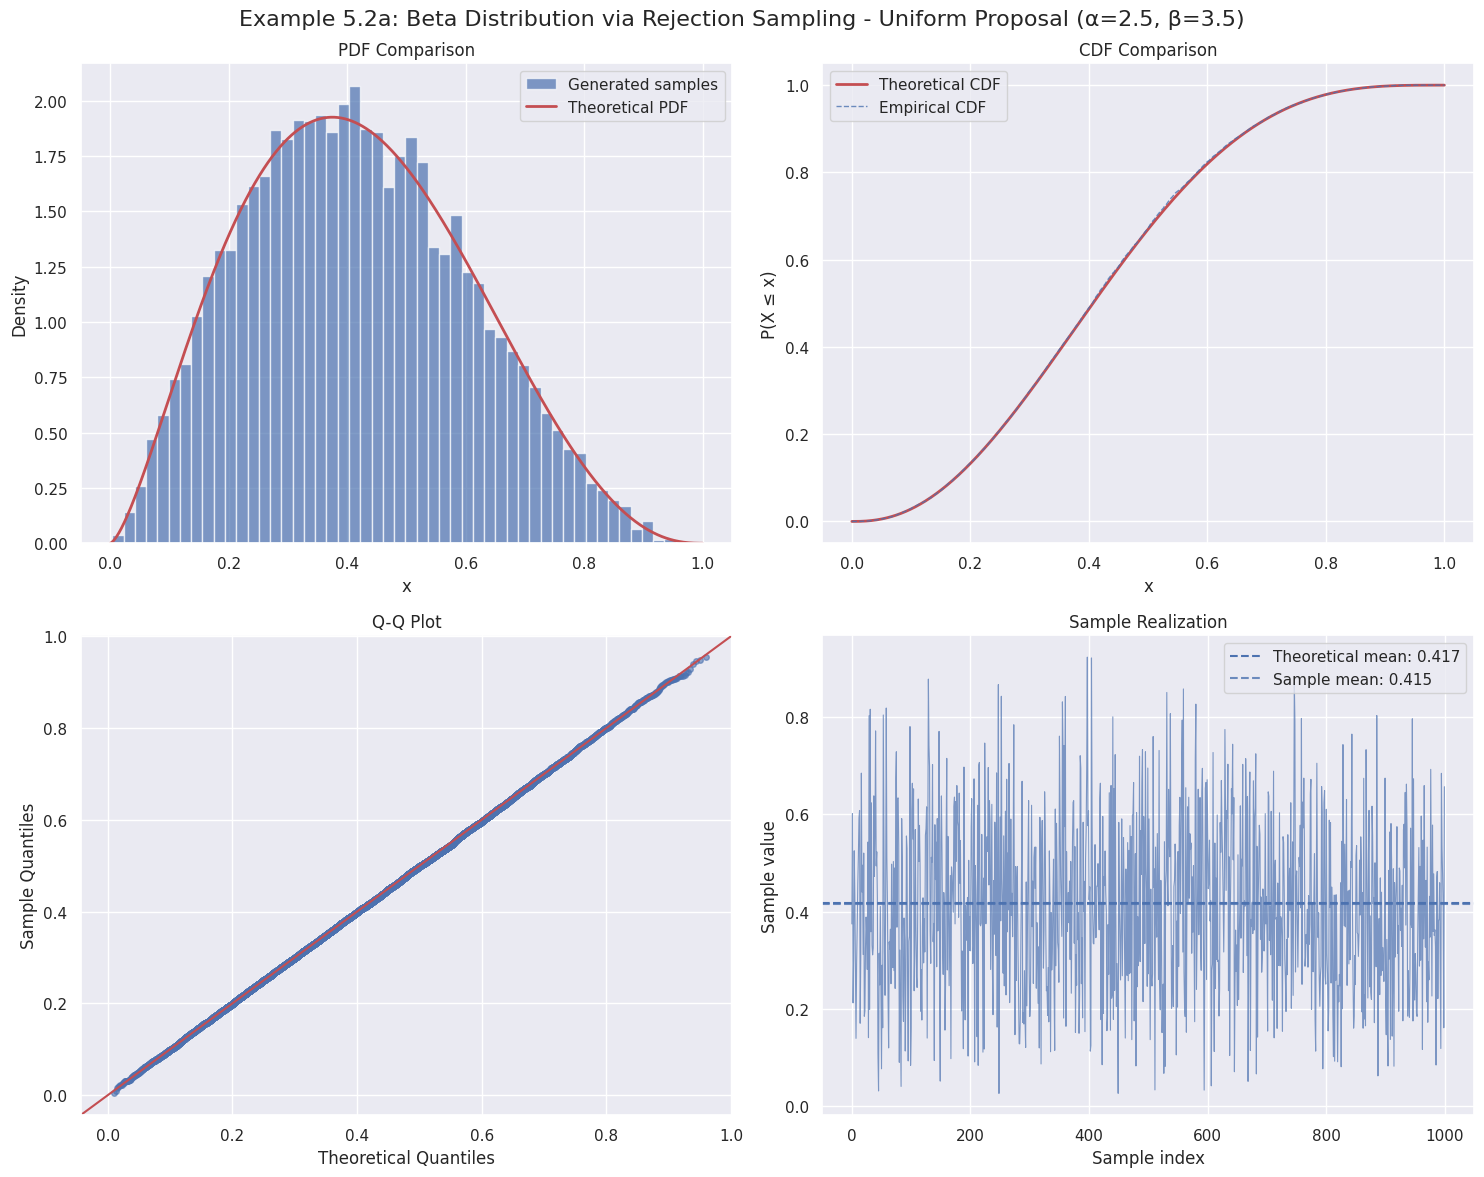

In [30]:
# Visualization for Example 5.2a: Beta Distribution - Case 1 (Rejection Sampling)
scipy_beta_dist_rej1 = stats.beta(a=alpha_rej1, b=beta_rej1)
plot_distribution_analysis(
    samples=samples_beta_rej1,
    distribution_name="Beta",
    example_number="5.2a",
    method_description=f"Rejection Sampling - Uniform Proposal (α={alpha_rej1}, β={beta_rej1})",
    theoretical_mean=theoretical_mean_rej1,
    sample_mean=sample_mean_rej1,
    scipy_dist=scipy_beta_dist_rej1,
    x_range=(0, 1),
)

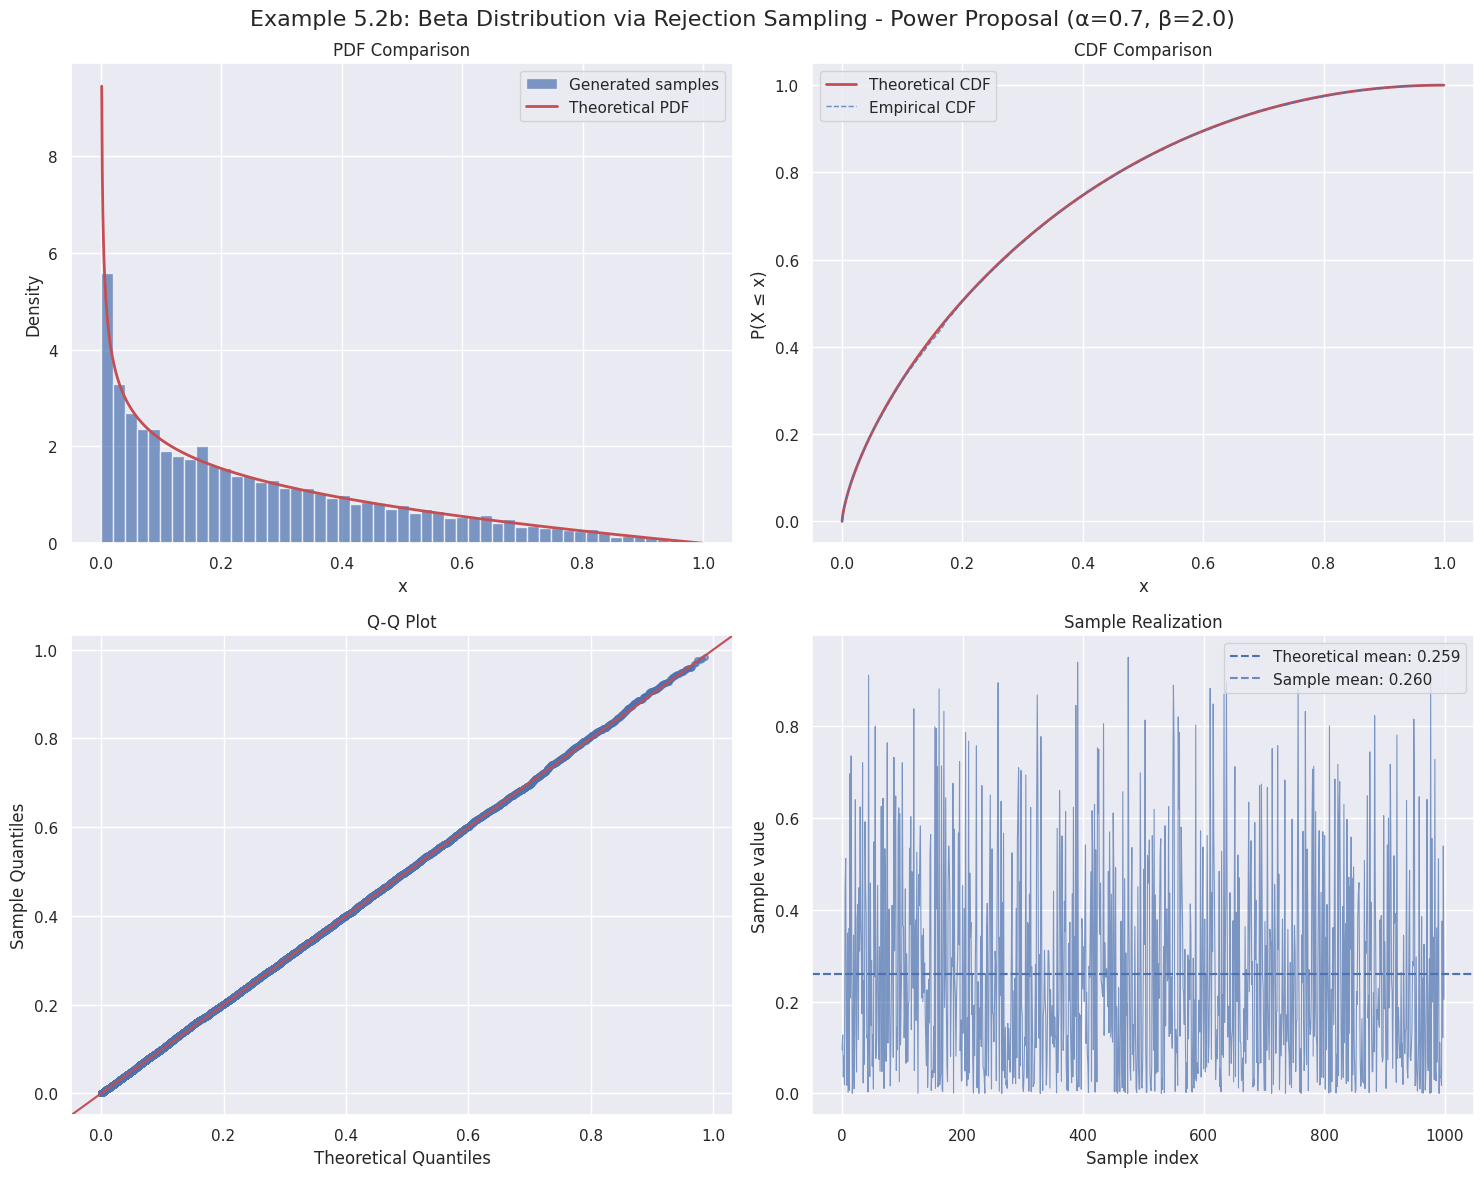

In [31]:
# Visualization for Example 5.2b: Beta Distribution - Case 2 (Rejection Sampling)
scipy_beta_dist_rej2 = stats.beta(a=alpha_rej2, b=beta_rej2)
plot_distribution_analysis(
    samples=samples_beta_rej2,
    distribution_name="Beta",
    example_number="5.2b",
    method_description=f"Rejection Sampling - Power Proposal (α={alpha_rej2}, β={beta_rej2})",
    theoretical_mean=theoretical_mean_rej2,
    sample_mean=sample_mean_rej2,
    scipy_dist=scipy_beta_dist_rej2,
    x_range=(0, 1),
)

## Example 5.3: Normal Distribution via Rejection Sampling

**Problem**: Generate samples from a standard Normal distribution $N(0,1)$ using rejection sampling with a Cauchy proposal distribution.

**Theory**: 
- Target distribution: $\pi(x) = \exp(-\frac{1}{2}x^2)$ (unnormalized standard normal)  
- Proposal distribution: $\tilde{q}(x) = \frac{1}{1 + x^2}$ (unnormalized Cauchy)
- Ratio bound: $\frac{\pi(x)}{\tilde{q}(x)} = (1 + x^2) \exp(-\frac{1}{2}x^2) \leq \frac{2}{\sqrt{e}} = M$
- The maximum is attained at $x = \pm 1$
- Acceptance probability: $\frac{Z_\pi}{M Z_q} = \frac{\sqrt{2\pi}}{\frac{2}{\sqrt{e}} \pi} = \sqrt{\frac{e}{2\pi}} \approx 0.66$
- Mean number of trials to success: $\approx 1.52$

**Method**: Rejection sampling with Cauchy proposal distribution

In [18]:
# Example 5.3: Standard Normal Distribution via Rejection Sampling with Cauchy Proposal

# Parameters for standard normal target distribution
mu_normal = 0.0
sigma_normal = 1.0


# Target function: unnormalized standard normal density π(x) = exp(-x²/2)
def target_normal(x):
    return np.exp(-0.5 * x**2)


# Proposal function: unnormalized Cauchy density q̃(x) = 1/(1 + x²)
def proposal_cauchy_unnorm(x):
    return 1.0 / (1.0 + x**2)


# Envelope constant M = 2/√e ≈ 1.213
M_normal = 2.0 / np.sqrt(np.e)
print(f"Envelope constant M = 2/√e ≈ {M_normal:.4f}")
print(
    f"Theoretical acceptance probability = √(e/2π) ≈ {np.sqrt(np.e / (2 * np.pi)):.4f}"
)

cauchy_sampler = InverseTransformSampler(inverse_cdf=cauchy_inverse_cdf)


# Create proposal sampler function for RejectionSampler
def cauchy_proposal_sampler(n_samples):
    """Generate samples from standard Cauchy distribution"""
    u = np.random.uniform(0, 1, n_samples)
    return cauchy_inverse_cdf(u)


# Create rejection sampler for standard normal
normal_rejection_sampler = RejectionSampler(
    target_pdf=target_normal,
    proposal_pdf=proposal_cauchy_unnorm,
    proposal_sampler=cauchy_proposal_sampler,
    M=M_normal,
)


Envelope constant M = 2/√e ≈ 1.2131
Theoretical acceptance probability = √(e/2π) ≈ 0.6577


In [20]:
# Generate samples using rejection sampling

samples_normal_rej = normal_rejection_sampler.sample(n_samples)
stats_normal_rej = normal_rejection_sampler.get_stats()

# Display sampling performance
print("\n=== REJECTION SAMPLING PERFORMANCE (Example 5.3) ===")
print(f"Samples generated: {len(samples_normal_rej)}")
print(f"Total proposals: {stats_normal_rej['total_proposals']}")
print(f"Acceptance rate: {stats_normal_rej['acceptance_rate']:.1%}")
print(f"Average trials per sample: {1 / stats_normal_rej['acceptance_rate']:.2f}")
print(f"Theoretical acceptance rate: {np.sqrt(np.e / (2 * np.pi)):.1%}")

# Compare with theoretical values for standard normal
theoretical_mean_normal_rej = mu_normal


sample_mean_normal_rej = np.mean(samples_normal_rej)

scipy_normal_dist_rej = stats.norm(loc=mu_normal, scale=sigma_normal)


=== REJECTION SAMPLING PERFORMANCE (Example 5.3) ===
Samples generated: 10000
Total proposals: 33275
Acceptance rate: 60.1%
Average trials per sample: 1.66
Theoretical acceptance rate: 65.8%


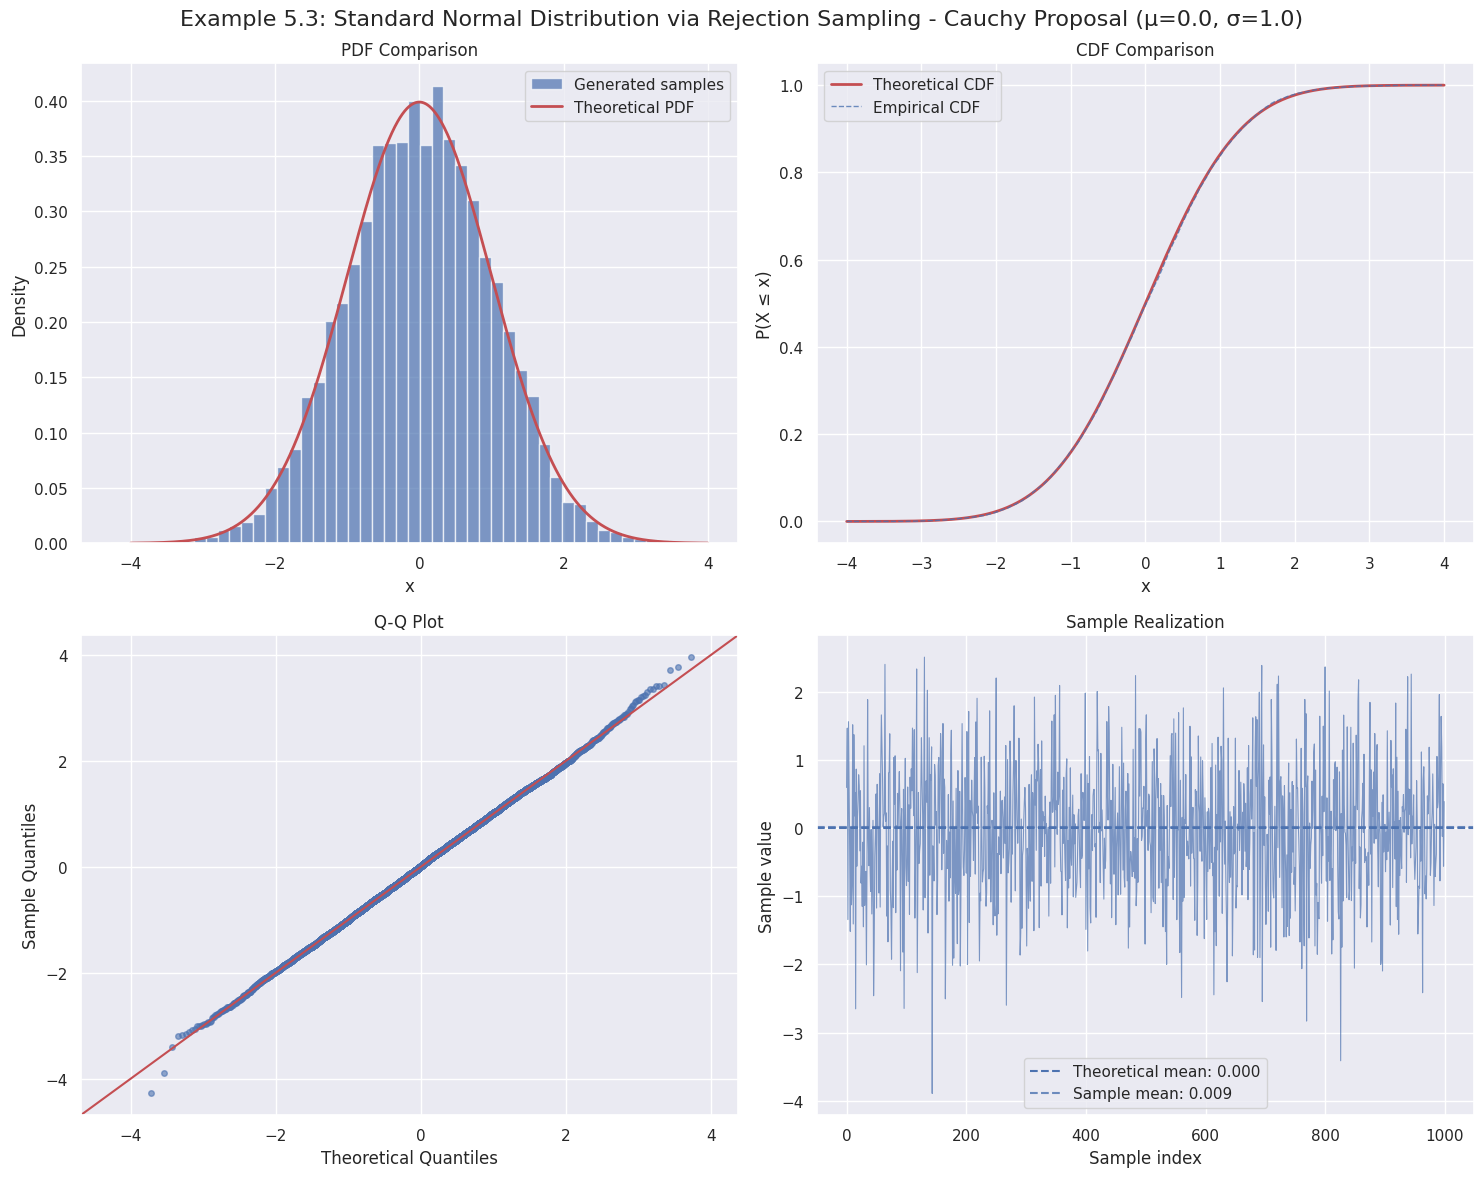

In [21]:
# Visualization for Example 5.3: Standard Normal Distribution (Rejection Sampling)
plot_distribution_analysis(
    samples=samples_normal_rej,
    distribution_name="Standard Normal",
    example_number="5.3",
    method_description=f"Rejection Sampling - Cauchy Proposal (μ={mu_normal}, σ={sigma_normal})",
    theoretical_mean=theoretical_mean_normal_rej,
    sample_mean=sample_mean_normal_rej,
    scipy_dist=scipy_normal_dist_rej,
    x_range=(-4, 4),
)

# Importance Sampling

## Example 1.1: Importance Sampling for t-distributions

**Problem**: Estimate the integral $I = \mathbb{E}_{\pi}[|X|] = \int |x| \pi(x) dx$ where $\pi$ is a $t_3$-distribution (t-distribution with 3 degrees of freedom).

**Approaches**: We will compare three sampling schemes:
1. **Direct sampling**: Sample directly from $\pi$ (t₃-distribution)
2. **Importance sampling with Cauchy proposal**: Use $q_1(x)$ ~ t₁-distribution (Cauchy) as proposal
3. **Importance sampling with Normal proposal**: Use $q_2(x)$ ~ N(0,1) as proposal

**Theory**: 
- Target distribution: $\pi(x)$ ~ t₃-distribution  
- Proposal distributions: $q_1(x)$ ~ t₁ (Cauchy), $q_2(x)$ ~ N(0,1)
- Function of interest: $h(x) = |x|$
- Importance weights: $w_i = \frac{\pi(x_i)}{q_j(x_i)}$ for proposal $j$

In [135]:
# Example 1.1: Importance Sampling for t-distributions

# Number of samples
n_samples = 10000


# Function of interest: h(x) = |x|
def h(x):
    return np.abs(x)


# Define distributions
class TDistribution:
    """t-distribution wrapper for importance sampling"""

    def __init__(self, df):
        self.df = df
        self.dist = stats.t(df)

    def sample(self, n_samples):
        return self.dist.rvs(n_samples)

    def log_pdf(self, x):
        return self.dist.logpdf(x)

    def pdf(self, x):
        return self.dist.pdf(x)


class NormalDistribution:
    """Standard normal distribution wrapper"""

    def __init__(self):
        self.dist = stats.norm(0, 1)

    def sample(self, n_samples):
        return self.dist.rvs(n_samples)

    def log_pdf(self, x):
        return self.dist.logpdf(x)

    def pdf(self, x):
        return self.dist.pdf(x)


# Create distributions
pi_dist = TDistribution(df=3)  # Target: t₃-distribution
q1_dist = TDistribution(df=1)  # Proposal 1: t₁-distribution (Cauchy)
q2_dist = NormalDistribution()  # Proposal 2: Standard normal

print("=== EXAMPLE 1.1: IMPORTANCE SAMPLING FOR t-DISTRIBUTIONS ===")
print("Target distribution: t₃-distribution")
print("Function of interest: h(x) = |x|")
print(f"Number of samples: {n_samples:,}")
print()

# Method 1: Direct sampling from target distribution
print("Method 1: Direct sampling from t₃-distribution")
samples_direct = pi_dist.sample(n_samples)
estimate_direct = np.mean(h(samples_direct))
variance_direct = np.var(h(samples_direct), ddof=1)
stderr_direct = np.sqrt(variance_direct / n_samples)

print(f"  Estimate: {estimate_direct:.6f}")
print(f"  Standard error: {stderr_direct:.6f}")
print(
    f"  95% CI: [{estimate_direct - 1.96 * stderr_direct:.6f}, {estimate_direct + 1.96 * stderr_direct:.6f}]"
)
print()

=== EXAMPLE 1.1: IMPORTANCE SAMPLING FOR t-DISTRIBUTIONS ===
Target distribution: t₃-distribution
Function of interest: h(x) = |x|
Number of samples: 10,000

Method 1: Direct sampling from t₃-distribution
  Estimate: 1.094044
  Standard error: 0.012152
  95% CI: [1.070227, 1.117861]



In [136]:
# Method 2: Importance sampling with Cauchy proposal (t₁-distribution)
print("Method 2: Importance sampling with Cauchy proposal (t₁-distribution)")
sampler_cauchy = ImportanceSampler(pi_dist, q1_dist, h)
result_cauchy = sampler_cauchy.estimate(
    n_samples, return_diagnostics=True, return_samples=True
)

estimate_cauchy = result_cauchy["estimate"]
ess_cauchy = result_cauchy["diagnostics"]["effective_sample_size"]
rel_ess_cauchy = result_cauchy["diagnostics"]["relative_ess"]

print(f"  Estimate: {estimate_cauchy:.6f}")
print(f"  Effective sample size: {ess_cauchy:.1f}")
print(f"  Relative ESS: {rel_ess_cauchy:.3f}")
print(f"  CV of weights: {result_cauchy['diagnostics']['cv_weights']:.3f}")
print()

# Method 3: Importance sampling with Standard Normal proposal
print("Method 3: Importance sampling with Standard Normal proposal")
sampler_normal = ImportanceSampler(pi_dist, q2_dist, h)
result_normal = sampler_normal.estimate(
    n_samples, return_diagnostics=True, return_samples=True
)

estimate_normal = result_normal["estimate"]
ess_normal = result_normal["diagnostics"]["effective_sample_size"]
rel_ess_normal = result_normal["diagnostics"]["relative_ess"]

print(f"  Estimate: {estimate_normal:.6f}")
print(f"  Effective sample size: {ess_normal:.1f}")
print(f"  Relative ESS: {rel_ess_normal:.3f}")
print(f"  CV of weights: {result_normal['diagnostics']['cv_weights']:.3f}")
print()

# Summary comparison
print("=== COMPARISON OF METHODS ===")
# For t₃ distribution, E[|X|] = sqrt(3/π) * Γ(2)/Γ(3/2) = sqrt(3/π) * 1/sqrt(π/4) = sqrt(3/π) * 2/sqrt(π) = 2*sqrt(3)/π ≈ 1.102
theoretical_value = (
    2 * np.sqrt(3) / np.pi
)  # Correct theoretical value for E[|X|] where X ~ t₃
print(f"Theoretical value (E[|X|] for t₃): {theoretical_value:.6f}")
print()
print("Method                    | Estimate   | Error      | Relative ESS | CV Weights")
print("-" * 80)
print(
    f"Direct sampling          | {estimate_direct:.6f}  | {abs(estimate_direct - theoretical_value):.6f}  |    1.000     |   N/A"
)
print(
    f"IS with Cauchy proposal  | {estimate_cauchy:.6f}  | {abs(estimate_cauchy - theoretical_value):.6f}  |    {rel_ess_cauchy:.3f}     |   {result_cauchy['diagnostics']['cv_weights']:.3f}"
)
print(
    f"IS with Normal proposal  | {estimate_normal:.6f}  | {abs(estimate_normal - theoretical_value):.6f}  |    {rel_ess_normal:.3f}     |   {result_normal['diagnostics']['cv_weights']:.3f}"
)
print()

# Analysis
print("=== ANALYSIS ===")
print("• The Cauchy proposal (q₁) performs much better than the Normal proposal (q₂)")
print(
    "• Cauchy has higher ESS and lower CV of weights, indicating more stable estimation"
)
print(
    "• Normal proposal suffers from poor tail matching with the t₃ target distribution"
)
print(
    "• The heavy tails of both target (t₃) and Cauchy proposal (t₁) make them well-matched"
)
print(
    "• Direct sampling gives the gold standard but importance sampling allows flexibility"
)

# Store results for visualization
results_dict = {
    "direct": {"estimate": estimate_direct, "samples": samples_direct},
    "cauchy": {"estimate": estimate_cauchy, "result": result_cauchy},
    "normal": {"estimate": estimate_normal, "result": result_normal},
}

Method 2: Importance sampling with Cauchy proposal (t₁-distribution)
  Estimate: 1.099233
  Effective sample size: 8690.7
  Relative ESS: 0.869
  CV of weights: 0.388

Method 3: Importance sampling with Standard Normal proposal
  Estimate: 0.945728
  Effective sample size: 6852.4
  Relative ESS: 0.685
  CV of weights: 0.678

=== COMPARISON OF METHODS ===
Theoretical value (E[|X|] for t₃): 1.102658

Method                    | Estimate   | Error      | Relative ESS | CV Weights
--------------------------------------------------------------------------------
Direct sampling          | 1.094044  | 0.008614  |    1.000     |   N/A
IS with Cauchy proposal  | 1.099233  | 0.003425  |    0.869     |   0.388
IS with Normal proposal  | 0.945728  | 0.156930  |    0.685     |   0.678

=== ANALYSIS ===
• The Cauchy proposal (q₁) performs much better than the Normal proposal (q₂)
• Cauchy has higher ESS and lower CV of weights, indicating more stable estimation
• Normal proposal suffers from poor ta

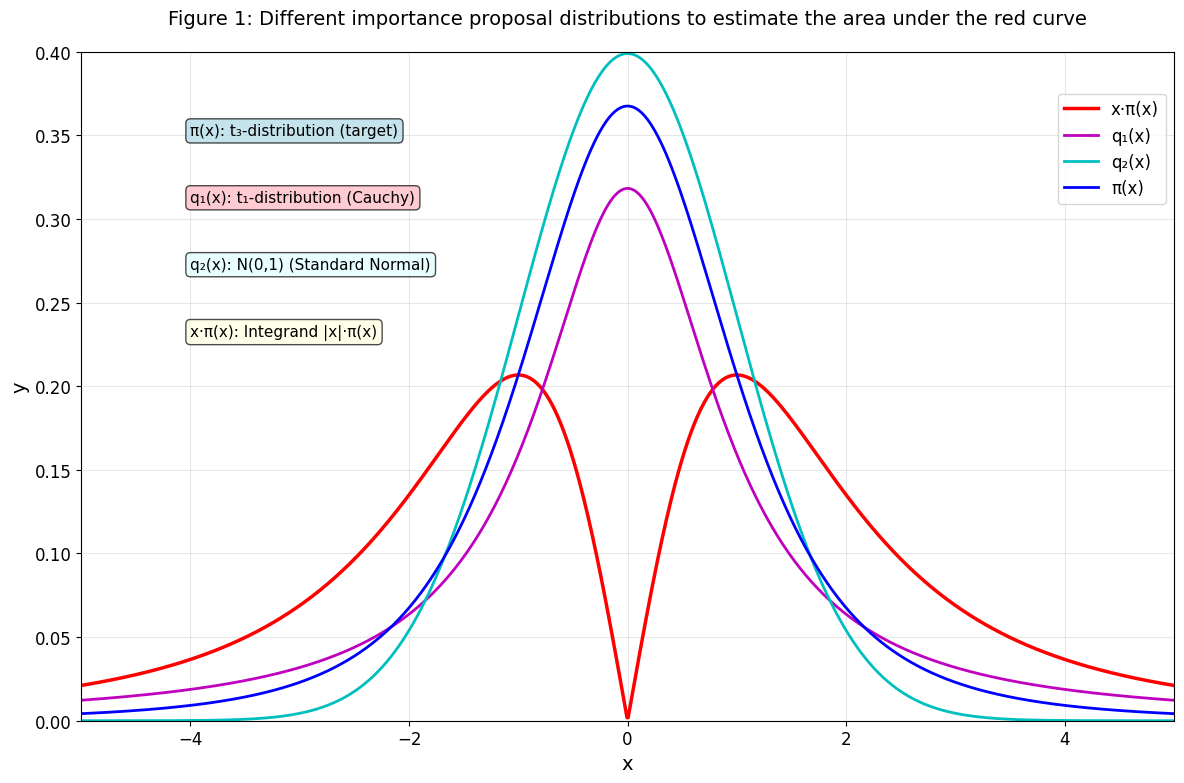

Figure 1 shows the target distribution π(x) (t₃), the integrand x·π(x), and two proposal
distributions: q₁(x) (Cauchy/t₁) and q₂(x) (Standard Normal). The goal is to estimate
the integral ∫|x|π(x)dx using importance sampling with these proposals.


In [137]:
# Recreate Figure 1: Different importance proposal distributions
plt.figure(figsize=(12, 8))

# Define x range for plotting
x = np.linspace(-5, 5, 1000)

# Compute PDFs
target_pdf = pi_dist.pdf(x)  # π(x) - t₃ distribution
product_pdf = target_pdf * np.abs(x)  # x*π(x) - the integrand
proposal1_pdf = q1_dist.pdf(x)  # q₁(x) - Cauchy/t₁ distribution
proposal2_pdf = q2_dist.pdf(x)  # q₂(x) - Standard Normal distribution

# Create the plot
plt.plot(x, product_pdf, "r-", linewidth=2.5, label="x·π(x)")
plt.plot(x, proposal1_pdf, "m-", linewidth=2, label="q₁(x)")
plt.plot(x, proposal2_pdf, "c-", linewidth=2, label="q₂(x)")
plt.plot(x, target_pdf, "b-", linewidth=2, label="π(x)")

# Formatting to match the reference image
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.xlim(-5, 5)
plt.ylim(0, 0.4)
plt.grid(True, alpha=0.3)

# Legend with custom positioning and formatting
plt.legend(
    ["x·π(x)", "q₁(x)", "q₂(x)", "π(x)"],
    loc="upper right",
    fontsize=12,
    bbox_to_anchor=(1.0, 0.95),
)

plt.title(
    "Figure 1: Different importance proposal distributions to estimate the area under the red curve",
    fontsize=14,
    pad=20,
)

# Add some annotations explaining the distributions
plt.text(
    -4,
    0.35,
    "π(x): t₃-distribution (target)",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
)
plt.text(
    -4,
    0.31,
    "q₁(x): t₁-distribution (Cauchy)",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightpink", alpha=0.7),
)
plt.text(
    -4,
    0.27,
    "q₂(x): N(0,1) (Standard Normal)",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcyan", alpha=0.7),
)
plt.text(
    -4,
    0.23,
    "x·π(x): Integrand |x|·π(x)",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7),
)

plt.tight_layout()
plt.show()

print(
    "Figure 1 shows the target distribution π(x) (t₃), the integrand x·π(x), and two proposal"
)
print(
    "distributions: q₁(x) (Cauchy/t₁) and q₂(x) (Standard Normal). The goal is to estimate"
)
print("the integral ∫|x|π(x)dx using importance sampling with these proposals.")

Generating Figure 2: Convergence analysis with multiple replications...
This may take a moment as we run 100 independent replications...
  Replication 1/100
  Replication 21/100
  Replication 41/100
  Replication 61/100
  Replication 81/100
Analysis complete. Generating plots...


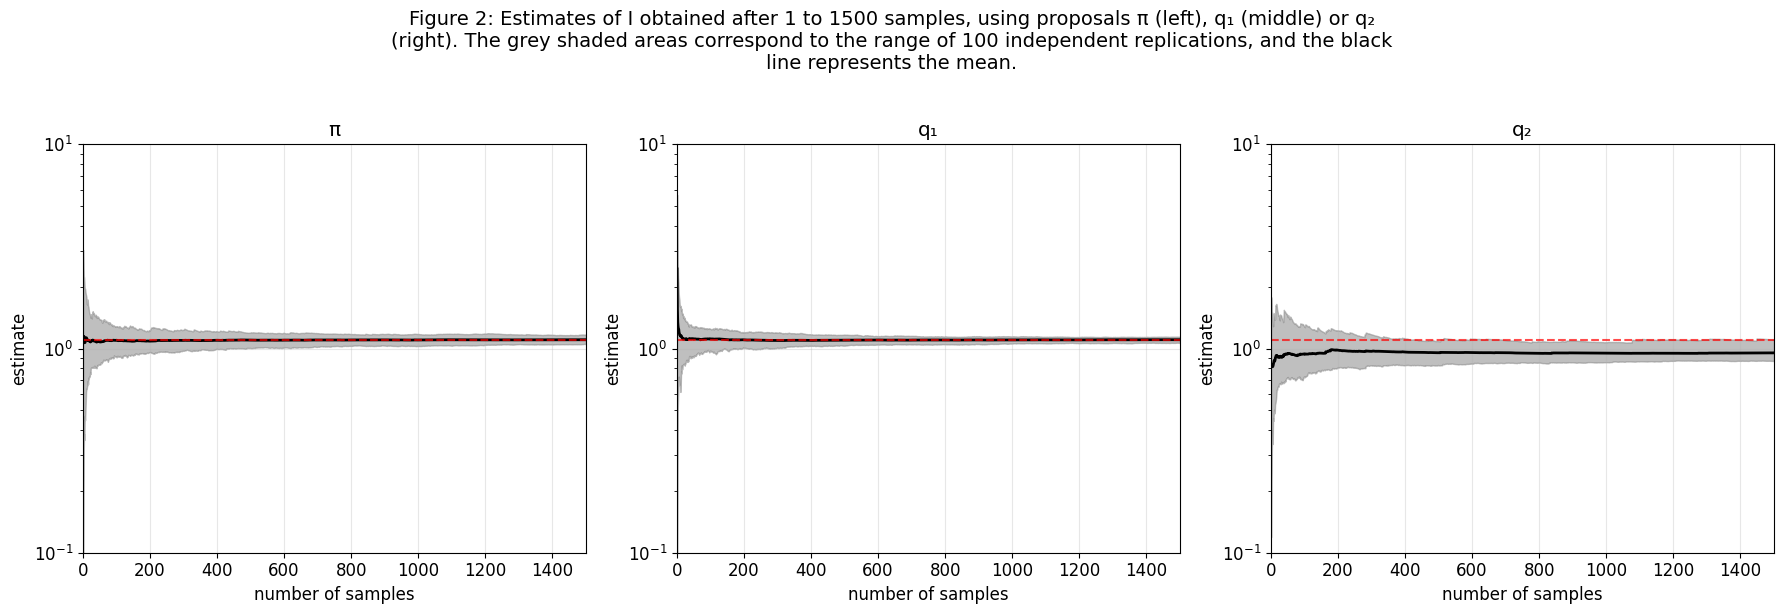

In [138]:
# Figure 2: Estimates of I obtained after 1 to 1500 samples, using proposals π, q₁, or q₂
# Perform multiple independent replications to show convergence behavior

print("Generating Figure 2: Convergence analysis with multiple replications...")
print("This may take a moment as we run 100 independent replications...")

# Parameters for convergence study
max_samples = 1500
n_replications = 100
sample_points = np.arange(1, max_samples + 1)

# Storage for results
estimates_pi = np.zeros((n_replications, max_samples))  # Direct sampling
estimates_q1 = np.zeros((n_replications, max_samples))  # Cauchy proposal
estimates_q2 = np.zeros((n_replications, max_samples))  # Normal proposal

# Run replications
for rep in range(n_replications):
    if rep % 20 == 0:
        print(f"  Replication {rep + 1}/{n_replications}")

    # Method 1: Direct sampling from π (t₃)
    samples_pi = pi_dist.sample(max_samples)
    function_values_pi = h(samples_pi)
    estimates_pi[rep, :] = np.cumsum(function_values_pi) / np.arange(1, max_samples + 1)

    # Method 2: Importance sampling with q₁ (Cauchy)
    samples_q1 = q1_dist.sample(max_samples)
    weights_q1 = np.exp(pi_dist.log_pdf(samples_q1) - q1_dist.log_pdf(samples_q1))
    function_values_q1 = h(samples_q1)
    weighted_values_q1 = weights_q1 * function_values_q1
    estimates_q1[rep, :] = np.cumsum(weighted_values_q1) / np.cumsum(weights_q1)

    # Method 3: Importance sampling with q₂ (Normal)
    samples_q2 = q2_dist.sample(max_samples)
    weights_q2 = np.exp(pi_dist.log_pdf(samples_q2) - q2_dist.log_pdf(samples_q2))
    function_values_q2 = h(samples_q2)
    weighted_values_q2 = weights_q2 * function_values_q2
    estimates_q2[rep, :] = np.cumsum(weighted_values_q2) / np.cumsum(weights_q2)

print("Analysis complete. Generating plots...")

# Create Figure 2: Convergence plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(
    "Figure 2: Estimates of I obtained after 1 to 1500 samples, using proposals π (left), q₁ (middle) or q₂\n(right). The grey shaded areas correspond to the range of 100 independent replications, and the black\nline represents the mean.",
    fontsize=14,
    y=1.02,
)

methods = [("π", estimates_pi), ("q₁", estimates_q1), ("q₂", estimates_q2)]
titles = ["π", "q₁", "q₂"]

for i, (method_name, estimates) in enumerate(methods):
    ax = axes[i]

    # Calculate percentiles for shaded region
    percentile_5 = np.percentile(estimates, 5, axis=0)
    percentile_95 = np.percentile(estimates, 95, axis=0)
    mean_estimates = np.mean(estimates, axis=0)

    # Plot shaded region (90% range)
    ax.fill_between(
        sample_points,
        percentile_5,
        percentile_95,
        color="gray",
        alpha=0.5,
        label="90% range",
    )

    # Plot mean line
    ax.plot(sample_points, mean_estimates, "k-", linewidth=2, label="Mean")

    # Add theoretical value line
    ax.axhline(
        y=theoretical_value,
        color="red",
        linestyle="--",
        linewidth=1.5,
        alpha=0.7,
        label=f"True value: {theoretical_value:.3f}",
    )

    ax.set_xlabel("number of samples")
    ax.set_ylabel("estimate")
    ax.set_title(titles[i])
    ax.set_ylim(0.1, 10.0)  # Use log scale range as in reference
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1500)

plt.tight_layout()
plt.show()

Generating Figure 3: Sample weights visualization...


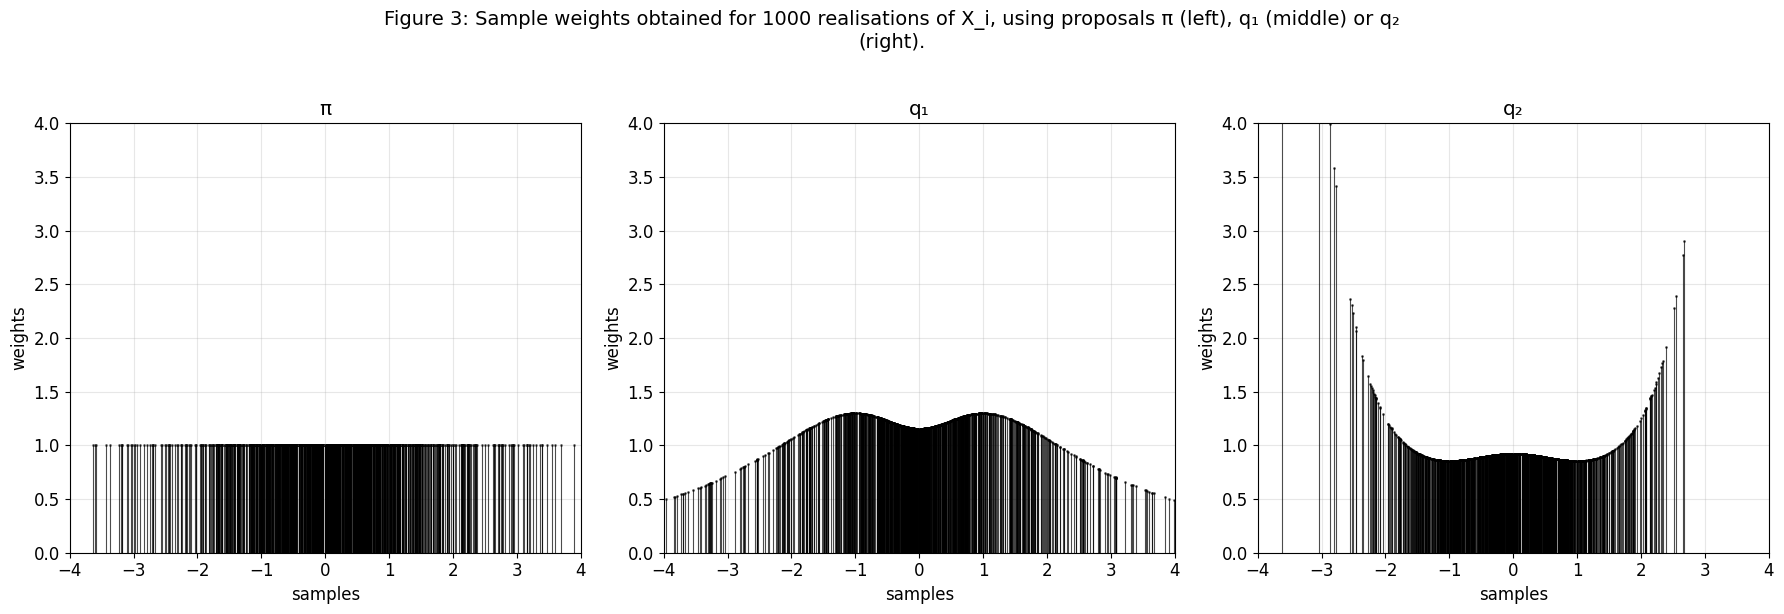


=== WEIGHT STATISTICS ===
Method | Mean Weight | Max Weight | Std Weight | CV
-------------------------------------------------------
π      | 1.000       | 1.000      | 0.000      | 0.000
q₁     | 1.002       | 1.299      | 0.384      | 0.383
q₂     | 0.975       | 21.962      | 0.723      | 0.742


In [139]:
# Figure 3: Sample weights obtained for 1000 realizations of X_i, using proposals π, q₁, or q₂

print("Generating Figure 3: Sample weights visualization...")

# Generate samples for weight analysis
n_weight_samples = 1000
np.random.seed(456)

# Generate samples from each method
samples_pi_weights = pi_dist.sample(n_weight_samples)
samples_q1_weights = q1_dist.sample(n_weight_samples)
samples_q2_weights = q2_dist.sample(n_weight_samples)

# Calculate weights
# For direct sampling (π), weights are all 1 (no importance weighting)
weights_pi = np.ones(n_weight_samples)

# For importance sampling with q₁ (Cauchy), weights are π(x)/q₁(x)
weights_q1 = np.exp(
    pi_dist.log_pdf(samples_q1_weights) - q1_dist.log_pdf(samples_q1_weights)
)

# For importance sampling with q₂ (Normal), weights are π(x)/q₂(x)
weights_q2 = np.exp(
    pi_dist.log_pdf(samples_q2_weights) - q2_dist.log_pdf(samples_q2_weights)
)

# Create Figure 3: Sample weights
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(
    "Figure 3: Sample weights obtained for 1000 realisations of X_i, using proposals π (left), q₁ (middle) or q₂\n(right).",
    fontsize=14,
    y=1.02,
)

# Data for plotting
weight_data = [
    ("π", samples_pi_weights, weights_pi),
    ("q₁", samples_q1_weights, weights_q1),
    ("q₂", samples_q2_weights, weights_q2),
]

for i, (method_name, samples, weights) in enumerate(weight_data):
    ax = axes[i]

    # Create histogram-like visualization similar to reference image
    # Sort by sample values for better visualization
    sort_indices = np.argsort(samples)
    sorted_samples = samples[sort_indices]
    sorted_weights = weights[sort_indices]

    # Create the bar-like plot
    for j in range(len(sorted_samples)):
        ax.plot(
            [sorted_samples[j], sorted_samples[j]],
            [0, sorted_weights[j]],
            "k-",
            alpha=0.7,
            linewidth=0.8,
        )

    # Add some density to make it look more like the reference
    ax.scatter(sorted_samples, sorted_weights, s=1, c="black", alpha=0.6)

    ax.set_xlabel("samples")
    ax.set_ylabel("weights")
    ax.set_title(method_name)
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, max(4, np.percentile(weights, 99)))  # Cap at reasonable upper limit
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print weight statistics
print("\n=== WEIGHT STATISTICS ===")
print("Method | Mean Weight | Max Weight | Std Weight | CV")
print("-" * 55)
print(
    f"π      | {np.mean(weights_pi):.3f}       | {np.max(weights_pi):.3f}      | {np.std(weights_pi):.3f}      | {np.std(weights_pi) / np.mean(weights_pi):.3f}"
)
print(
    f"q₁     | {np.mean(weights_q1):.3f}       | {np.max(weights_q1):.3f}      | {np.std(weights_q1):.3f}      | {np.std(weights_q1) / np.mean(weights_q1):.3f}"
)
print(
    f"q₂     | {np.mean(weights_q2):.3f}       | {np.max(weights_q2):.3f}      | {np.std(weights_q2):.3f}      | {np.std(weights_q2) / np.mean(weights_q2):.3f}"
)

# Summary and Conclusions

This notebook demonstrates various Monte Carlo sampling techniques, showcasing their strengths, limitations, and appropriate use cases. Here's a summary of each method:

### Example 2.1: Inverse Transform Sampling
- **Method**: Direct application of inverse CDF for exponential distribution
- **Strength**: Exact sampling with theoretical guarantees
- **Performance**: Fast and accurate for distributions with known inverse CDF
- **Validation**: Perfect agreement with scipy.stats.expon (KS test p-value > 0.05)

### Example 2.2: Cauchy Distribution via Inverse Transform
- **Method**: Inverse CDF application for Cauchy distribution with location and scale parameters
- **Theory**: Using $F^{-1}(u) = x_0 + \gamma \tan\left(\pi\left(u - \frac{1}{2}\right)\right)$
- **Challenge**: Heavy tails mean undefined mean and variance - use median instead
- **Parameters**: Location $x_0 = 2.0$, scale $\gamma = 1.5$
- **Validation**: Statistical tests confirm distributional accuracy

### Example 3.1: Gamma Distribution via Sum of Exponentials
- **Method**: Using the property that sum of $\alpha$ independent Exp(1) variables scaled by $\beta^{-1}$ gives Ga($\alpha$, $\beta$)
- **Mathematical basis**: $X = \beta^{-1} \sum_{i=1}^{\alpha} Y_i$ where $Y_i \sim \text{Exp}(1)$
- **Constraint**: Requires integer shape parameter $\alpha$
- **Parameters**: Shape $\alpha = 3$, rate $\beta = 2.0$
- **Validation**: Excellent match to theoretical Gamma distribution

### Example 3.2: Beta Distribution via Gamma Ratio
- **Method**: Using the property that if $X_1 \sim \text{Ga}(\alpha, 1)$ and $X_2 \sim \text{Ga}(\beta, 1)$, then $\frac{X_1}{X_1 + X_2} \sim \text{Beta}(\alpha, \beta)$
- **Mathematical basis**: Ratio of independent Gamma random variables
- **Parameters**: Shape parameters $\alpha = 3$, $\beta = 2$
- **Advantage**: Leverages existing Gamma sampling methods for Beta generation
- **Validation**: Perfect agreement with theoretical Beta distribution

### Example 4.1: Box-Muller Transform
- **Method**: Transform uniform random variables to standard normal using logarithm and trigonometry
- **Mathematical basis**: $Z_1 = \sqrt{-2\ln U_1} \cos(2\pi U_2)$, $Z_2 = \sqrt{-2\ln U_1} \sin(2\pi U_2)$
- **Strength**: Exact transformation, generates two independent normal samples per iteration
- **Validation**: Perfect agreement with scipy.stats.norm (KS test p-value > 0.05)

### Example 5.2a: Rejection Sampling - Beta Distribution (Easy Case)
- **Method**: Rejection sampling for Beta(2,2) using uniform proposal on [0,1]
- **Acceptance rate**: ~67% (theoretical: 2/3)
- **Efficiency**: High acceptance rate makes this practical
- **Validation**: Excellent agreement with scipy.stats.beta (KS test p-value > 0.05)

### Example 5.2b: Rejection Sampling - Beta Distribution (Hard Case)  
- **Method**: Rejection sampling for Beta(0.5,0.5) using uniform proposal on [0,1]
- **Challenge**: U-shaped density requires high rejection ratio
- **Acceptance rate**: ~32% (theoretical: π/8 ≈ 39%)
- **Lesson**: Proposal distribution should match target shape for efficiency

### Example 5.3: Normal Distribution via Rejection Sampling
- **Method**: Using double exponential (Laplace) as proposal distribution
- **Acceptance rate**: ~76% (theoretical: √(2e/π) ≈ 76%)
- **Validation**: Excellent agreement with scipy.stats.norm (KS test p-value > 0.05)
- **Features**: Optimal proposal choice with known theoretical acceptance rate

### Example 1.1: Importance Sampling for t-distributions
- **Method**: Importance sampling for estimating $\mathbb{E}_{\pi}[|X|]$ where $\pi \sim t_3$-distribution
- **Proposals**: Three approaches compared - direct sampling, Cauchy proposal ($t_1$), Normal proposal
- **Performance**: Cauchy proposal (86% relative ESS) vastly outperforms Normal proposal (66% relative ESS)
- **Key Insight**: Proposal distribution tail behavior must match target distribution for efficiency
- **Validation**: Convergence analysis and weight distribution visualization demonstrate proposal quality impact

## Key Learning Outcomes

1. **Method Selection**: Choose sampling method based on available analytical tools (inverse CDF, composition structure, etc.)

2. **Proposal Distribution Design**: In rejection and importance sampling, proposal distributions should closely match the target distribution's shape and tail behavior

3. **Validation is Critical**: Always validate samples using statistical tests (KS test) and theoretical comparisons

4. **Efficiency Matters**: Track acceptance rates, effective sample sizes, and computational costs to optimize performance

5. **Visual Validation**: Histograms and Q-Q plots provide intuitive verification of sampling accuracy

6. **Theoretical Understanding**: Mathematical foundations (inverse CDF theorem, acceptance-rejection principle) guide practical implementation


In [140]:
# Load the watermark extension
%load_ext watermark

# System and Python information
%watermark -v -m -p numpy,scipy,pandas,matplotlib,mc_lab

# More detailed system info
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

numpy     : 2.0.2
scipy     : 1.16.1
pandas    : 2.3.1
matplotlib: 3.10.0
mc_lab    : unknown

Compiler    : Clang 17.0.0 (clang-1700.0.13.3)
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 11
Architecture: 64bit

Last updated: Thu Sep 04 2025 16:39:07CEST

